In [ ]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import json
import logging
import time
from tqdm import tqdm
from typing import Dict, List, Optional

# Set up logging
logging.basicConfig(level=logging.INFO, 
                   format='%(asctime)s - %(levelname)s - %(message)s')

def compute_normalized_diff(initial: np.ndarray, final: np.ndarray) -> float:
    """
    Compute normalized difference between initial and final kernels using spectral norm.
    Added epsilon to prevent division by zero.
    """
    epsilon = 1e-10
    norm_initial = np.linalg.norm(initial, ord=2)
    norm_final = np.linalg.norm(final, ord=2)
    return np.linalg.norm(final - initial, ord=2) / (norm_initial + norm_final + epsilon)

def validate_kernel_data(nngp: np.ndarray, ntk: np.ndarray) -> bool:
    """Validate kernel data for potential issues"""
    if np.any(np.isnan(nngp)) or np.any(np.isnan(ntk)):
        return False
    if np.any(np.isinf(nngp)) or np.any(np.isinf(ntk)):
        return False
    if nngp.size == 0 or ntk.size == 0:
        return False
    return True

def get_mode_from_history(base_filename: str, results_dir: str) -> str:
    """Extract mode from corresponding history file with better error handling"""
    try:
        history_files = glob.glob(os.path.join(results_dir, f"history_*{base_filename}*.json"))
        if not history_files:
            logging.warning(f"No history file found for {base_filename}")
            return 'unknown'
            
        with open(history_files[0], 'r') as f:
            history = json.load(f)
            mode = history.get('parameters', {}).get('mode', 'unknown')
            if mode == 'unknown':
                logging.warning(f"Mode not found in history file for {base_filename}")
            return mode
    except Exception as e:
        logging.error(f"Error reading history file for {base_filename}: {e}")
        return 'unknown'

def load_dataset_chunks(dataset):
    """Load HDF5 dataset in chunks to manage memory usage"""
    chunk_size = 1000
    shape = dataset.shape
    result = np.zeros(shape, dtype=dataset.dtype)
    for i in range(0, shape[0], chunk_size):
        end = min(i + chunk_size, shape[0])
        result[i:end] = dataset[i:end]
    return result

def analyze_kernels(results_dir: str) -> List[Dict]:
    """Analyze kernel files with improved error handling and validation"""
    kernel_files = glob.glob(os.path.join(results_dir, "*_kernels.h5"))
    if not kernel_files:
        logging.error(f"No kernel files found in {results_dir}")
        return []
    
    results = []
    for file_path in tqdm(kernel_files, desc="Processing kernel files"):
        basename = os.path.basename(file_path)
        if "initial" not in basename and "best_model" not in basename:
            continue
            
        try:
            # Extract parameters from filename
            parts = basename.split('_')
            config_str = '_'.join([p for p in parts if p.startswith(('h', 'd', 'n', 'lr'))])
            mode = get_mode_from_history(config_str, results_dir)
            
            hidden_size = int([p for p in parts if p.startswith('h')][0][1:])
            n_train = int([p for p in parts if p.startswith('n')][0][1:])
            is_initial = "initial" in basename
            
            # Try to open with different HDF5 versions
            try:
                with h5py.File(file_path, 'r', libver='earliest') as f:
                    nngp = load_dataset_chunks(f['nngp'])
                    ntk = load_dataset_chunks(f['ntk'])
                    epoch = f.attrs.get('epoch', -1)
            except OSError:
                with h5py.File(file_path, 'r', libver='latest') as f:
                    nngp = load_dataset_chunks(f['nngp'])
                    ntk = load_dataset_chunks(f['ntk'])
                    epoch = f.attrs.get('epoch', -1)
            
            if not validate_kernel_data(nngp, ntk):
                logging.warning(f"Invalid kernel data in {basename}")
                continue
                
            results.append({
                'hidden_size': hidden_size,
                'n_train': n_train,
                'mode': mode,
                'is_initial': is_initial,
                'nngp': nngp,
                'ntk': ntk,
                'epoch': epoch,
                'file': basename
            })
                
        except Exception as e:
            logging.error(f"Error processing {basename}: {e}")
            continue
    
    # Group results by configuration
    grouped_results = {}
    for r in results:
        key = f"h{r['hidden_size']}_n{r['n_train']}_mode{r['mode']}"
        if key not in grouped_results:
            grouped_results[key] = {'initial': None, 'final': None}
        if r['is_initial']:
            grouped_results[key]['initial'] = r
        else:
            grouped_results[key]['final'] = r
    
    # Compute differences
    differences = []
    for key, pair in grouped_results.items():
        if pair['initial'] is not None and pair['final'] is not None:
            initial, final = pair['initial'], pair['final']
            
            # Validate shapes match
            if initial['nngp'].shape != final['nngp'].shape or initial['ntk'].shape != final['ntk'].shape:
                logging.warning(f"Shape mismatch in {key}")
                continue
                
            nngp_diff = compute_normalized_diff(initial['nngp'], final['nngp'])
            ntk_diff = compute_normalized_diff(initial['ntk'], final['ntk'])
            
            # Validate differences are reasonable
            if not (0 <= nngp_diff <= 1 and 0 <= ntk_diff <= 1):
                logging.warning(f"Suspicious difference values in {key}")
                continue
                
            differences.append({
                'hidden_size': initial['hidden_size'],
                'n_train': initial['n_train'],
                'mode': initial['mode'],
                'nngp_diff': nngp_diff,
                'ntk_diff': ntk_diff
            })
            logging.info(f"Processed {key}: NNGP diff = {nngp_diff:.4f}, NTK diff = {ntk_diff:.4f}")
    
    return differences

def plot_kernel_differences(differences: List[Dict], output_dir: str) -> None:
    """Create plots with improved error handling and timeouts"""
    logging.info("Starting plotting function...")
    
    # Immediately return if no differences
    if not differences:
        logging.error("No valid differences to plot")
        return
    
    # Print data summary for debugging
    unique_sizes = sorted(set(d['hidden_size'] for d in differences))
    unique_trains = sorted(set(d['n_train'] for d in differences))
    unique_modes = sorted(set(d['mode'] for d in differences))
    
    logging.info(f"Data summary before plotting:")
    logging.info(f"Hidden sizes: {unique_sizes}")
    logging.info(f"Training sizes: {unique_trains}")
    logging.info(f"Modes: {unique_modes}")
    logging.info(f"Total differences: {len(differences)}")
    if not differences:
        logging.error("No valid differences to plot")
        return
        
    logging.info(f"Starting to plot {len(differences)} differences...")
    
    # Separate data by mode with validation
    standard_data = [d for d in differences if d['mode'] == 'standard']
    mup_data = [d for d in differences if d['mode'] == 'mup_pennington']
    
    logging.info(f"Found {len(standard_data)} standard and {len(mup_data)} MuP data points")
    
    # Configure plot style
    plt.style.use('seaborn-v0_8')
    colors = sns.color_palette("husl", 8)
    
    def create_single_plot(data_std: List[Dict], data_mup: List[Dict], x_key: str, y_key: str, 
                   fixed_key: str, fixed_values: List, xlabel: str, ylabel: str, 
                   title: str, filename: str) -> None:
        logging.info(f"Creating plot: {filename}")
        try:
            plt.clf()  # Clear any existing plots
            fig, ax = plt.subplots(figsize=(12, 8))
            
            for i, fixed_val in enumerate(fixed_values):
                # Plot standard initialization
                points_std = [d for d in data_std if d[fixed_key] == fixed_val]
                if points_std:
                    x = [d[x_key] for d in points_std]
                    y = [d[y_key] for d in points_std]
                    points = sorted(zip(x, y))
                    x, y = zip(*points)
                    ax.plot(x, y, 'o-', color=colors[i], 
                           label=f'Standard {fixed_key}={fixed_val}', 
                           markersize=8)
                
                # Plot MuP initialization
                points_mup = [d for d in data_mup if d[fixed_key] == fixed_val]
                if points_mup:
                    x = [d[x_key] for d in points_mup]
                    y = [d[y_key] for d in points_mup]
                    points = sorted(zip(x, y))
                    x, y = zip(*points)
                    ax.plot(x, y, 's--', color=colors[i], 
                           label=f'MuP {fixed_key}={fixed_val}', 
                           markersize=8)
            
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlabel(xlabel, fontsize=12)
            ax.set_ylabel(ylabel, fontsize=12)
            ax.set_title(title, fontsize=14)
            ax.grid(True, which="both", ls="-", alpha=0.2)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
            
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight', dpi=300)
            logging.info(f"Saved plot: {filename}")
            plt.close('all')
            
        except Exception as e:
            logging.error(f"Error creating plot {filename}: {e}")
            plt.close('all')
    
    # Plot configurations
    plot_configs = [
        ('hidden_size', 'ntk_diff', 'n_train', n_train_values, 'Width', 
         'Normalized NTK Difference', 'NTK Difference vs Width', 'ntk_vs_width.png'),
        ('n_train', 'ntk_diff', 'hidden_size', width_values, 'Training Set Size', 
         'Normalized NTK Difference', 'NTK Difference vs Training Set Size', 'ntk_vs_ntrain.png'),
        ('hidden_size', 'nngp_diff', 'n_train', n_train_values, 'Width', 
         'Normalized NNGP Difference', 'NNGP Difference vs Width', 'nngp_vs_width.png'),
        ('n_train', 'nngp_diff', 'hidden_size', width_values, 'Training Set Size', 
         'Normalized NNGP Difference', 'NNGP Difference vs Training Set Size', 'nngp_vs_ntrain.png')
    ]
    
    # Get unique values for plots
    n_train_values = sorted(set(d['n_train'] for d in differences))
    width_values = sorted(set(d['hidden_size'] for d in differences))
    
    logging.info("Starting to create individual plots...")
    
    for i, config in enumerate(plot_configs, 1):
        try:
            logging.info(f"Creating plot {i} of {len(plot_configs)}: {config[7]}")
            create_single_plot(standard_data, mup_data, *config)
            logging.info(f"Successfully created plot {i}")
            
            # Force cleanup after each plot
            plt.close('all')
            
        except Exception as e:
            logging.error(f"Error creating plot {i}: {e}")
            plt.close('all')
            continue
    
    logging.info("Finished creating all plots")

def main():
    """Main function with proper cleanup and error handling"""
    start_time = time.time()
    logging.info("Starting analysis...")
    try:
        # Configuration
        results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_small_data_change"
        output_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/plots"
        os.makedirs(output_dir, exist_ok=True)
        
        # Analyze kernels
        differences = analyze_kernels(results_dir)
        
        if not differences:
            logging.error("No valid kernel differences found")
            return
        
        # Print summary before plotting
        print(f"\nAnalyzed {len(differences)} kernel pairs")
        print("\nUnique configurations:")
        print(f"Hidden sizes: {sorted(set(d['hidden_size'] for d in differences))}")
        print(f"Training sizes: {sorted(set(d['n_train'] for d in differences))}")
        print(f"Modes: {sorted(set(d['mode'] for d in differences))}")
        
        logging.info("Starting plotting phase...")
        
        # Create plots with timeout protection
        try:
            plot_kernel_differences(differences, output_dir)
        except Exception as e:
            logging.error(f"Error in plotting phase: {e}")
        
        end_time = time.time()
        logging.info(f"Total execution time: {end_time - start_time:.2f} seconds")
        
    except Exception as e:
        logging.error(f"Error in main: {e}")
    finally:
        # Cleanup
        try:
            plt.close('all')
            logging.info("Matplotlib cleanup completed")
        except Exception as e:
            logging.error(f"Error during cleanup: {e}")
        
        logging.info("Program finished.")

if __name__ == "__main__":
    main()

2025-01-03 16:55:56,294 - INFO - Starting analysis...
Processing kernel files:   1%|          | 1/107 [00:08<14:31,  8.22s/it]2025-01-03 16:56:04,535 - WARNING - No history file found for data_h100_d4_n100_lr0.05
2025-01-03 16:56:04,545 - WARNING - No history file found for data_h1000_d4_n500_lr0.05
2025-01-03 16:56:04,568 - WARNING - No history file found for data_h1000_d4_n1000_lr0.05
Processing kernel files:   4%|▎         | 4/107 [00:08<02:43,  1.59s/it]2025-01-03 16:56:04,649 - WARNING - No history file found for data_h100_d4_n1100_lr0.05
2025-01-03 16:56:04,761 - WARNING - No history file found for data_h100_d4_n500_lr0.05
Processing kernel files:   6%|▌         | 6/107 [00:08<01:33,  1.08it/s]2025-01-03 16:56:04,789 - WARNING - No history file found for data_h1000_d4_n1000_lr0.05
2025-01-03 16:56:04,874 - WARNING - No history file found for data_h500_d4_n1100_lr0.05
Processing kernel files:   7%|▋         | 8/107 [00:08<01:00,  1.64it/s]2025-01-03 16:56:04,988 - WARNING - No his

In [2]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import json
import logging
import time
from concurrent.futures import ThreadPoolExecutor
from typing import Dict, List, Optional
from functools import lru_cache
from pathlib import Path

# Set up logging with less verbose format
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')

# Global cache for history files
HISTORY_CACHE = {}

@lru_cache(maxsize=1000)
def compute_normalized_diff(initial_flat: tuple, final_flat: tuple) -> float:
    """
    Compute normalized difference with caching and optimized computation.
    Convert arrays to tuples for hashability in cache.
    """
    initial = np.array(initial_flat)
    final = np.array(final_flat)
    epsilon = 1e-10
    # Use faster numpy operations
    norm_diff = np.linalg.norm(final - initial)
    norm_sum = np.linalg.norm(initial) + np.linalg.norm(final)
    return norm_diff / (norm_sum + epsilon)

def validate_kernel_data(data: np.ndarray) -> bool:
    """Optimized validation using numpy's built-in functions"""
    return not (np.any(np.isnan(data)) or np.any(np.isinf(data)) or data.size == 0)

def preload_history_files(results_dir: str) -> None:
    """Preload all history files into memory cache with debug logging"""
    history_files = glob.glob(os.path.join(results_dir, "history_*.json"))
    logging.info(f"Found {len(history_files)} history files")
    
    for file_path in history_files:
        try:
            with open(file_path, 'r') as f:
                history = json.load(f)
                base_name = Path(file_path).stem.replace('history_', '')
                # Fix: Directly access the mode parameter
                mode = history["parameters"]["mode"]
                HISTORY_CACHE[base_name] = mode
                logging.debug(f"Loaded history for {base_name}: mode = {mode}")
        except Exception as e:
            logging.warning(f"Error loading {file_path}: {e}")
            continue
    
    logging.info(f"Successfully cached {len(HISTORY_CACHE)} history files")

def analyze_kernels(results_dir: str) -> List[Dict]:
    """Analyze kernel files with parallel processing and debug logging"""
    kernel_files = glob.glob(os.path.join(results_dir, "*_kernels.h5"))
    logging.info(f"Found {len(kernel_files)} kernel files")

    # Preload history files
    preload_history_files(results_dir)
    
    # Process files in parallel
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        results = list(filter(None, executor.map(process_single_kernel, kernel_files)))
    
    logging.info(f"Processed {len(results)} kernel files successfully")
    
    # Add debug logging for modes
    modes = set(r['mode'] for r in results)
    logging.info(f"Found modes in results: {modes}")
    
    # Group results by configuration using dictionary comprehension
    grouped_results = {
        f"h{r['hidden_size']}_n{r['n_train']}_mode{r['mode']}": 
        {'initial': r} if r['is_initial'] else {'final': r}
        for r in results
    }
    
    logging.info(f"Grouped into {len(grouped_results)} configurations")
    
    # Compute differences for valid pairs
    differences = []
    for key, pair in grouped_results.items():
        if not (pair.get('initial') and pair.get('final')):
            logging.debug(f"Skipping {key}: missing initial or final")
            continue
            
        initial, final = pair['initial'], pair['final']
        if initial['nngp'].shape != final['nngp'].shape:
            logging.debug(f"Skipping {key}: shape mismatch")
            continue
            
        # Compute diffs using cached function
        nngp_diff = compute_normalized_diff(tuple(initial['nngp'].flatten()), 
                                         tuple(final['nngp'].flatten()))
        ntk_diff = compute_normalized_diff(tuple(initial['ntk'].flatten()), 
                                        tuple(final['ntk'].flatten()))
        
        if not (0 <= nngp_diff <= 1 and 0 <= ntk_diff <= 1):
            logging.debug(f"Skipping {key}: invalid diff values")
            continue
            
        differences.append({
            'hidden_size': initial['hidden_size'],
            'n_train': initial['n_train'],
            'mode': initial['mode'],
            'nngp_diff': nngp_diff,
            'ntk_diff': ntk_diff
        })
    
    logging.info(f"Generated {len(differences)} valid differences")
    # Log what modes we have in the differences
    modes_in_diffs = set(d['mode'] for d in differences)
    logging.info(f"Modes in differences: {modes_in_diffs}")
    
    return differences

def get_mode_from_history(base_filename: str) -> str:
    """Get mode from cached history files"""
    return HISTORY_CACHE.get(base_filename, 'unknown')

def process_single_kernel(file_path: str) -> Optional[Dict]:
    """Process a single kernel file with optimized loading"""
    basename = os.path.basename(file_path)
    if "initial" not in basename and "best_model" not in basename:
        return None
        
    try:
        # Extract parameters using faster string operations
        parts = basename.split('_')
        hidden_size = int(next(p[1:] for p in parts if p.startswith('h')))
        n_train = int(next(p[1:] for p in parts if p.startswith('n')))
        config_str = '_'.join(p for p in parts if p.startswith(('h', 'd', 'n', 'lr')))
        mode = get_mode_from_history(config_str)
        is_initial = "initial" in basename

        # Optimized file reading with context manager
        with h5py.File(file_path, 'r') as f:
            # Use direct slice access instead of load_dataset_chunks
            nngp = f['nngp'][:]
            ntk = f['ntk'][:]
            epoch = f.attrs.get('epoch', -1)

        # Quick validation
        if not (validate_kernel_data(nngp) and validate_kernel_data(ntk)):
            return None

        return {
            'hidden_size': hidden_size,
            'n_train': n_train,
            'mode': mode,
            'is_initial': is_initial,
            'nngp': nngp,
            'ntk': ntk,
            'epoch': epoch,
            'file': basename
        }

    except Exception as e:
        logging.debug(f"Error processing {basename}: {e}")
        return None



def plot_kernel_differences(differences: List[Dict], output_dir: str) -> None:
    """Create plots with optimized rendering"""
    if not differences:
        logging.error("No valid differences to plot")
        return

    # Pre-process data once
    standard_data = [d for d in differences if d['mode'] == 'standard']
    mup_data = [d for d in differences if d['mode'] == 'mup_pennington']
    n_train_values = sorted(set(d['n_train'] for d in differences))
    width_values = sorted(set(d['hidden_size'] for d in differences))

    # Set global plot style once
    plt.style.use('seaborn-v0_8')
    colors = sns.color_palette("husl", 8)

    def create_single_plot(data_std, data_mup, x_key, y_key, fixed_key, fixed_values,
                          xlabel, ylabel, title, filename):
        plt.figure(figsize=(12, 8))
        ax = plt.gca()

        for i, fixed_val in enumerate(fixed_values):
            # Plot standard initialization
            points_std = [(d[x_key], d[y_key]) 
                         for d in data_std 
                         if d[fixed_key] == fixed_val]
            if points_std:
                points_std.sort()
                x, y = zip(*points_std)
                ax.plot(x, y, 'o-', color=colors[i],
                       label=f'Standard {fixed_key}={fixed_val}',
                       markersize=8)

            # Plot MuP initialization
            points_mup = [(d[x_key], d[y_key])
                         for d in data_mup
                         if d[fixed_key] == fixed_val]
            if points_mup:
                points_mup.sort()
                x, y = zip(*points_mup)
                ax.plot(x, y, 's--', color=colors[i],
                       label=f'MuP {fixed_key}={fixed_val}',
                       markersize=8)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.grid(True, which="both", ls="-", alpha=0.2)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight', dpi=300)
        plt.close()

    # Plot configurations
    plot_configs = [
        ('hidden_size', 'ntk_diff', 'n_train', n_train_values, 'Width',
         'Normalized NTK Difference', 'NTK Difference vs Width', 'ntk_vs_width.png'),
        ('n_train', 'ntk_diff', 'hidden_size', width_values, 'Training Set Size',
         'Normalized NTK Difference', 'NTK Difference vs Training Set Size', 'ntk_vs_ntrain.png'),
        ('hidden_size', 'nngp_diff', 'n_train', n_train_values, 'Width',
         'Normalized NNGP Difference', 'NNGP Difference vs Width', 'nngp_vs_width.png'),
        ('n_train', 'nngp_diff', 'hidden_size', width_values, 'Training Set Size',
         'Normalized NNGP Difference', 'NNGP Difference vs Training Set Size', 'nngp_vs_ntrain.png')
    ]

    # Create plots
    for config in plot_configs:
        create_single_plot(standard_data, mup_data, *config)

def main():
    """Main function with timing and error handling"""
    start_time = time.time()
    logging.info("Starting analysis...")
    
    try:
        # Configuration
        results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_small_data_change"
        output_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/plots"
        os.makedirs(output_dir, exist_ok=True)

        # Analyze kernels
        differences = analyze_kernels(results_dir)
        if not differences:
            logging.error("No valid kernel differences found")
            return

        # Print summary
        logging.info(f"\nAnalyzed {len(differences)} kernel pairs")
        logging.info(f"Hidden sizes: {sorted(set(d['hidden_size'] for d in differences))}")
        logging.info(f"Training sizes: {sorted(set(d['n_train'] for d in differences))}")
        logging.info(f"Modes: {sorted(set(d['mode'] for d in differences))}")

        # Create plots
        plot_kernel_differences(differences, output_dir)
        
        end_time = time.time()
        logging.info(f"Total execution time: {end_time - start_time:.2f} seconds")

    except Exception as e:
        logging.error(f"Error in main: {e}")
    finally:
        plt.close('all')

if __name__ == "__main__":
    main()

2025-01-03 17:21:29,609 - INFO - Starting analysis...
2025-01-03 17:21:29,614 - INFO - Found 107 kernel files
2025-01-03 17:21:29,616 - INFO - Found 53 history files
2025-01-03 17:21:30,093 - INFO - Successfully cached 53 history files
2025-01-03 17:22:48,181 - INFO - Processed 107 kernel files successfully
2025-01-03 17:22:48,184 - INFO - Found modes in results: {'unknown'}
2025-01-03 17:22:48,186 - INFO - Grouped into 28 configurations
2025-01-03 17:22:48,187 - INFO - Generated 0 valid differences
2025-01-03 17:22:48,189 - INFO - Modes in differences: set()
2025-01-03 17:22:48,828 - ERROR - No valid kernel differences found


In [5]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import json
import logging
import time
import torch
from concurrent.futures import ThreadPoolExecutor
from typing import Dict, List, Optional
from functools import lru_cache
from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')

# Global cache for history files
HISTORY_CACHE = {}

@lru_cache(maxsize=1000)
def compute_normalized_diff(initial_flat: tuple, final_flat: tuple) -> float:
    """
    Compute normalized difference with caching and optimized computation.
    Convert arrays to tuples for hashability in cache.
    """
    initial = np.array(initial_flat)
    final = np.array(final_flat)
    epsilon = 1e-10
    norm_diff = np.linalg.norm(final - initial)
    norm_sum = np.linalg.norm(initial) + np.linalg.norm(final)
    return norm_diff / (norm_sum + epsilon)

def validate_model_data(data: np.ndarray) -> bool:
    """Validate model parameters"""
    return not (np.any(np.isnan(data)) or np.any(np.isinf(data)) or data.size == 0)

def load_model_state(file_path: str) -> np.ndarray:
    """Load PyTorch model state and convert to flattened numpy array"""
    try:
        state_dict = torch.load(file_path, map_location=torch.device('cpu'))
        # Concatenate all parameters into a single tensor
        params = []
        for param in state_dict.values():
            params.append(param.view(-1))
        return torch.cat(params).numpy()
    except Exception as e:
        logging.error(f"Error loading model file {file_path}: {str(e)}")
        raise

def extract_config_from_filename(filename: str) -> Dict:
    """Extract configuration from filename"""
    parts = filename.split('_')
    config = {}
    
    # Extract hidden size
    for part in parts:
        if part.startswith('h') and part[1:].isdigit():
            config['hidden_size'] = int(part[1:])
            break
            
    # Extract n_train
    for part in parts:
        if part.startswith('n') and not part.startswith('ntk') and part[1:].isdigit():
            config['n_train'] = int(part[1:])
            break
    
    # Extract rank number
    rank_part = next((p for p in parts if p.startswith('rank')), None)
    if rank_part:
        config['rank'] = int(rank_part[4:].split('.')[0])
    
    # Determine model type
    if 'initial_model' in filename:
        config['model_type'] = 'initial'
    elif 'best_model' in filename:
        config['model_type'] = 'best'
    elif 'final_model' in filename:
        config['model_type'] = 'final'
    
    return config

def preload_history_files(results_dir: str) -> None:
    """Preload all history files into memory cache"""
    history_files = glob.glob(os.path.join(results_dir, "history_*.json"))
    logging.info(f"Found {len(history_files)} history files")
    
    for file_path in history_files:
        try:
            with open(file_path, 'r') as f:
                history = json.load(f)
                config = extract_config_from_filename(os.path.basename(file_path))
                
                if not all(k in config for k in ['hidden_size', 'n_train', 'rank']):
                    logging.warning(f"Missing required fields in config for {file_path}")
                    continue
                
                key = f"h{config['hidden_size']}_n{config['n_train']}_rank{config['rank']}"
                mode = history["parameters"]["mode"]
                HISTORY_CACHE[key] = mode
                logging.debug(f"Cached {key}: mode = {mode}")
                
        except Exception as e:
            logging.warning(f"Error loading {file_path}: {str(e)}")
            continue
    
    logging.info(f"Successfully cached {len(HISTORY_CACHE)} history files")
    if HISTORY_CACHE:
        logging.info(f"Found modes: {set(HISTORY_CACHE.values())}")

def process_single_model(file_path: str) -> Optional[Dict]:
    """Process a single model file"""
    basename = os.path.basename(file_path)
    try:
        # Extract configuration
        config = extract_config_from_filename(basename)
        if not all(k in config for k in ['hidden_size', 'n_train', 'rank', 'model_type']):
            logging.debug(f"Missing required fields in config for {basename}")
            return None
        
        # Get mode from history cache
        key = f"h{config['hidden_size']}_n{config['n_train']}_rank{config['rank']}"
        mode = HISTORY_CACHE.get(key)
        
        if mode is None:
            logging.debug(f"No mode found for {key}")
            return None
        
        # Load model parameters
        model_params = load_model_state(file_path)
        
        if not validate_model_data(model_params):
            logging.debug(f"Invalid model parameters in {basename}")
            return None
        
        return {
            'hidden_size': config['hidden_size'],
            'n_train': config['n_train'],
            'mode': mode,
            'rank': config['rank'],
            'model_type': config['model_type'],
            'parameters': model_params,
            'file': basename
        }
        
    except Exception as e:
        logging.debug(f"Error processing {basename}: {str(e)}")
        return None

def analyze_models(results_dir: str) -> List[Dict]:
    """Analyze model files with parallel processing"""
    # Get all model files
    model_files = glob.glob(os.path.join(results_dir, "*model*.pt"))
    logging.info(f"Found {len(model_files)} model files")

    # Preload history files
    preload_history_files(results_dir)
    
    if not HISTORY_CACHE:
        logging.error("No history files were successfully loaded")
        return []
    
    # Process files in parallel
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        results = list(filter(None, executor.map(process_single_model, model_files)))
    
    logging.info(f"Processed {len(results)} model files successfully")
    
    # Group by configuration and rank
    grouped_results = {}
    for r in results:
        key = f"h{r['hidden_size']}_n{r['n_train']}_r{r['rank']}_mode{r['mode']}"
        if key not in grouped_results:
            grouped_results[key] = {}
        grouped_results[key][r['model_type']] = r

    # Compute differences
    differences = []
    for key, group in grouped_results.items():
        if not ('initial' in group and ('best' in group or 'final' in group)):
            continue
            
        initial = group['initial']
        final = group['best'] if 'best' in group else group['final']
        
        params_diff = compute_normalized_diff(
            tuple(initial['parameters'].flatten()),
            tuple(final['parameters'].flatten())
        )
        
        if not (0 <= params_diff <= 1):
            logging.debug(f"Invalid parameter difference for {key}")
            continue
            
        differences.append({
            'hidden_size': initial['hidden_size'],
            'n_train': initial['n_train'],
            'mode': initial['mode'],
            'params_diff': params_diff
        })

    logging.info(f"Generated {len(differences)} valid differences")
    modes_in_diffs = set(d['mode'] for d in differences)
    logging.info(f"Modes in differences: {modes_in_diffs}")
    return differences

def plot_differences(differences: List[Dict], output_dir: str) -> None:
    """Create plots with optimized rendering"""
    if not differences:
        logging.error("No valid differences to plot")
        return

    # Pre-process data
    standard_data = [d for d in differences if d['mode'] == 'standard']
    mup_data = [d for d in differences if d['mode'] == 'mup_pennington']
    n_train_values = sorted(set(d['n_train'] for d in differences))
    width_values = sorted(set(d['hidden_size'] for d in differences))

    logging.info(f"Found {len(standard_data)} standard and {len(mup_data)} MuP samples")

    # Set plot style
    plt.style.use('seaborn-v0_8')
    colors = sns.color_palette("husl", 8)

    def create_single_plot(data_std, data_mup, x_key, fixed_key, fixed_values,
                          xlabel, ylabel, title, filename):
        plt.figure(figsize=(12, 8))
        ax = plt.gca()

        for i, fixed_val in enumerate(fixed_values):
            # Plot standard initialization
            points_std = [(d[x_key], d['params_diff']) 
                         for d in data_std 
                         if d[fixed_key] == fixed_val]
            if points_std:
                points_std.sort()
                x, y = zip(*points_std)
                ax.plot(x, y, 'o-', color=colors[i],
                       label=f'Standard {fixed_key}={fixed_val}',
                       markersize=8)

            # Plot MuP initialization
            points_mup = [(d[x_key], d['params_diff'])
                         for d in data_mup
                         if d[fixed_key] == fixed_val]
            if points_mup:
                points_mup.sort()
                x, y = zip(*points_mup)
                ax.plot(x, y, 's--', color=colors[i],
                       label=f'MuP {fixed_key}={fixed_val}',
                       markersize=8)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.grid(True, which="both", ls="-", alpha=0.2)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight', dpi=300)
        plt.close()

    # Plot configurations
    plot_configs = [
        ('hidden_size', 'n_train', n_train_values, 'Width',
         'Parameter Distance', 'Parameter Change vs Width', 'params_vs_width.png'),
        ('n_train', 'hidden_size', width_values, 'Training Set Size',
         'Parameter Distance', 'Parameter Change vs Training Set Size', 'params_vs_ntrain.png')
    ]

    # Create plots
    for config in plot_configs:
        create_single_plot(standard_data, mup_data, *config)

def main():
    """Main function with timing and error handling"""
    start_time = time.time()
    logging.info("Starting analysis...")
    
    try:
        # Configuration
        results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_small_data_change"
        output_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/plots"
        os.makedirs(output_dir, exist_ok=True)

        # Analyze models
        differences = analyze_models(results_dir)
        if not differences:
            logging.error("No valid model differences found")
            return

        # Print summary
        logging.info(f"\nAnalyzed {len(differences)} model pairs")
        logging.info(f"Hidden sizes: {sorted(set(d['hidden_size'] for d in differences))}")
        logging.info(f"Training sizes: {sorted(set(d['n_train'] for d in differences))}")
        logging.info(f"Modes: {sorted(set(d['mode'] for d in differences))}")

        # Create plots
        plot_differences(differences, output_dir)
        
        end_time = time.time()
        logging.info(f"Total execution time: {end_time - start_time:.2f} seconds")

    except Exception as e:
        logging.error(f"Error in main: {e}")
    finally:
        plt.close('all')

if __name__ == "__main__":
    main()

2025-01-03 17:36:14,705 - INFO - Starting analysis...
2025-01-03 17:36:14,709 - INFO - Found 160 model files
2025-01-03 17:36:14,711 - INFO - Found 53 history files
2025-01-03 17:36:14,923 - INFO - Successfully cached 53 history files
2025-01-03 17:36:14,924 - INFO - Found modes: {'mup_pennington', 'standard'}
/tmp/ipykernel_2766958/1721092743.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.a

In [ ]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import json
import logging
import time
import torch
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from typing import Dict, List, Optional
from functools import lru_cache
from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')

# Global cache for history files
HISTORY_CACHE = {}

def compute_normalized_diff(initial: np.ndarray, final: np.ndarray) -> float:
    """Compute normalized difference"""
    epsilon = 1e-10
    norm_initial = np.linalg.norm(initial, ord=2)
    norm_final = np.linalg.norm(final, ord=2)
    return np.linalg.norm(final - initial, ord=2) / (norm_initial + norm_final + epsilon)

def validate_data(data: np.ndarray) -> bool:
    """Validate data for potential issues"""
    return not (np.any(np.isnan(data)) or np.any(np.isinf(data)) or data.size == 0)

def load_model_state(file_path: str) -> np.ndarray:
    """Load PyTorch model state and convert to flattened numpy array"""
    try:
        state_dict = torch.load(file_path, map_location=torch.device('cpu'))
        params = []
        for param in state_dict.values():
            params.append(param.view(-1))
        return torch.cat(params).numpy()
    except Exception as e:
        logging.error(f"Error loading model file {file_path}: {str(e)}")
        raise

def load_kernel_data(file_path: str) -> tuple:
    """Load kernel data from HDF5 file"""
    try:
        with h5py.File(file_path, 'r') as f:
            nngp = f['nngp'][:]
            ntk = f['ntk'][:]
            epoch = f.attrs.get('epoch', -1)
        return nngp, ntk, epoch
    except Exception as e:
        logging.error(f"Error loading kernel file {file_path}: {str(e)}")
        raise

def extract_config_from_filename(filename: str) -> Dict:
    """Extract configuration from filename"""
    parts = filename.split('_')
    config = {}
    
    # Extract hidden size and n_train
    for part in parts:
        if part.startswith('h') and part[1:].isdigit():
            config['hidden_size'] = int(part[1:])
        elif part.startswith('n') and not part.startswith('ntk') and part[1:].isdigit():
            config['n_train'] = int(part[1:])
    
    # Extract rank number
    rank_part = next((p for p in parts if p.startswith('rank')), None)
    if rank_part:
        config['rank'] = int(rank_part[4:].split('.')[0])
    
    # Determine model type
    if 'initial' in filename:
        config['model_type'] = 'initial'
    elif 'best_model' in filename:
        config['model_type'] = 'best'
    elif 'final' in filename:
        config['model_type'] = 'final'
        
    return config

def preload_history_files(results_dir: str) -> None:
    """Preload all history files into memory cache"""
    history_files = glob.glob(os.path.join(results_dir, "history_*.json"))
    logging.info(f"Found {len(history_files)} history files")
    
    for file_path in history_files:
        try:
            with open(file_path, 'r') as f:
                history = json.load(f)
                config = extract_config_from_filename(os.path.basename(file_path))
                key = f"h{config['hidden_size']}_n{config['n_train']}_rank{config['rank']}"
                mode = history["parameters"]["mode"]
                HISTORY_CACHE[key] = mode
        except Exception as e:
            logging.warning(f"Error loading {file_path}: {str(e)}")
    
    logging.info(f"Successfully cached {len(HISTORY_CACHE)} history files")
    if HISTORY_CACHE:
        logging.info(f"Found modes: {set(HISTORY_CACHE.values())}")

def analyze_files(results_dir: str) -> tuple:
    """Analyze both model and kernel files"""
    # Get all model and kernel files
    model_files = glob.glob(os.path.join(results_dir, "*model*.pt"))
    kernel_files = glob.glob(os.path.join(results_dir, "*_kernels.h5"))
    
    logging.info(f"Found {len(model_files)} model files and {len(kernel_files)} kernel files")

    # Preload history files
    preload_history_files(results_dir)
    
    if not HISTORY_CACHE:
        logging.error("No history files were successfully loaded")
        return [], []

    # Process model files
    model_results = []
    for file_path in tqdm(model_files, desc="Processing model files"):
        try:
            basename = os.path.basename(file_path)
            config = extract_config_from_filename(basename)
            key = f"h{config['hidden_size']}_n{config['n_train']}_rank{config['rank']}"
            mode = HISTORY_CACHE.get(key)
            
            if mode is None:
                continue
                
            params = load_model_state(file_path)
            
            if not validate_data(params):
                continue
                
            model_results.append({
                'hidden_size': config['hidden_size'],
                'n_train': config['n_train'],
                'mode': mode,
                'model_type': config['model_type'],
                'parameters': params,
                'file': basename
            })
        except Exception as e:
            logging.debug(f"Error processing model {basename}: {str(e)}")
            continue

    # Process kernel files
    kernel_results = []
    for file_path in tqdm(kernel_files, desc="Processing kernel files"):
        try:
            basename = os.path.basename(file_path)
            config = extract_config_from_filename(basename)
            key = f"h{config['hidden_size']}_n{config['n_train']}_rank{config['rank']}"
            mode = HISTORY_CACHE.get(key)
            
            if mode is None:
                continue
                
            nngp, ntk, epoch = load_kernel_data(file_path)
            
            if not (validate_data(nngp) and validate_data(ntk)):
                continue
                
            kernel_results.append({
                'hidden_size': config['hidden_size'],
                'n_train': config['n_train'],
                'mode': mode,
                'model_type': config['model_type'],
                'nngp': nngp,
                'ntk': ntk,
                'epoch': epoch,
                'file': basename
            })
        except Exception as e:
            logging.debug(f"Error processing kernel {basename}: {str(e)}")
            continue

    # Group and compute differences
    model_diffs = []
    kernel_diffs = []

    # Group model results and compute differences
    model_groups = {}
    for r in model_results:
        key = f"h{r['hidden_size']}_n{r['n_train']}_mode{r['mode']}"
        if key not in model_groups:
            model_groups[key] = {}
        model_groups[key][r['model_type']] = r

    for group in model_groups.values():
        if not ('initial' in group and ('best' in group or 'final' in group)):
            continue
            
        initial = group['initial']
        final = group['best'] if 'best' in group else group['final']
        
        params_diff = compute_normalized_diff(initial['parameters'], final['parameters'])
        
        if not (0 <= params_diff <= 1):
            continue
            
        model_diffs.append({
            'hidden_size': initial['hidden_size'],
            'n_train': initial['n_train'],
            'mode': initial['mode'],
            'params_diff': params_diff
        })

    # Group kernel results and compute differences
    kernel_groups = {}
    for r in kernel_results:
        key = f"h{r['hidden_size']}_n{r['n_train']}_mode{r['mode']}"
        if key not in kernel_groups:
            kernel_groups[key] = {}
        if 'initial' in r['file']:
            kernel_groups[key]['initial'] = r
        else:
            kernel_groups[key]['final'] = r

    for group in kernel_groups.values():
        if not ('initial' in group and 'final' in group):
            continue
            
        initial = group['initial']
        final = group['final']
        
        if initial['nngp'].shape != final['nngp'].shape:
            continue
            
        nngp_diff = compute_normalized_diff(initial['nngp'], final['nngp'])
        ntk_diff = compute_normalized_diff(initial['ntk'], final['ntk'])
        
        if not (0 <= nngp_diff <= 1 and 0 <= ntk_diff <= 1):
            continue
            
        kernel_diffs.append({
            'hidden_size': initial['hidden_size'],
            'n_train': initial['n_train'],
            'mode': initial['mode'],
            'nngp_diff': nngp_diff,
            'ntk_diff': ntk_diff
        })

    logging.info(f"Generated {len(model_diffs)} model differences and {len(kernel_diffs)} kernel differences")
    return model_diffs, kernel_diffs

def plot_differences(model_diffs: List[Dict], kernel_diffs: List[Dict], output_dir: str) -> None:
    """Create plots for both model and kernel differences"""
    if not model_diffs and not kernel_diffs:
        logging.error("No valid differences to plot")
        return

    # Configure plot style
    plt.style.use('seaborn-v0_8')
    colors = sns.color_palette("husl", 8)

    def create_plot(data_std, data_mup, x_key, y_key, fixed_key, fixed_values,
                   xlabel, ylabel, title, filename):
        plt.figure(figsize=(12, 8))
        ax = plt.gca()

        for i, fixed_val in enumerate(fixed_values):
            # Plot standard initialization
            points_std = [(d[x_key], d[y_key]) 
                         for d in data_std 
                         if d[fixed_key] == fixed_val]
            if points_std:
                points_std.sort()
                x, y = zip(*points_std)
                ax.plot(x, y, 'o-', color=colors[i],
                       label=f'Standard {fixed_key}={fixed_val}',
                       markersize=8)

            # Plot MuP initialization
            points_mup = [(d[x_key], d[y_key])
                         for d in data_mup
                         if d[fixed_key] == fixed_val]
            if points_mup:
                points_mup.sort()
                x, y = zip(*points_mup)
                ax.plot(x, y, 's--', color=colors[i],
                       label=f'MuP {fixed_key}={fixed_val}',
                       markersize=8)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.grid(True, which="both", ls="-", alpha=0.2)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight', dpi=300)
        plt.close()

    # Get unique values
    all_diffs = model_diffs + kernel_diffs
    n_train_values = sorted(set(d['n_train'] for d in all_diffs))
    width_values = sorted(set(d['hidden_size'] for d in all_diffs))

    # Separate data by mode
    if model_diffs:
        model_std = [d for d in model_diffs if d['mode'] == 'standard']
        model_mup = [d for d in model_diffs if d['mode'] == 'mup_pennington']
        logging.info(f"Found {len(model_std)} standard and {len(model_mup)} MuP model differences")

        # Plot model parameter differences
        plot_configs = [
            ('hidden_size', 'params_diff', 'n_train', n_train_values, 'Width',
             'Parameter Distance', 'Parameter Change vs Width', 'params_vs_width.png'),
            ('n_train', 'params_diff', 'hidden_size', width_values, 'Training Set Size',
             'Parameter Distance', 'Parameter Change vs Training Set Size', 'params_vs_ntrain.png')
        ]

        for config in plot_configs:
            create_plot(model_std, model_mup, *config)

    if kernel_diffs:
        kernel_std = [d for d in kernel_diffs if d['mode'] == 'standard']
        kernel_mup = [d for d in kernel_diffs if d['mode'] == 'mup_pennington']
        logging.info(f"Found {len(kernel_std)} standard and {len(kernel_mup)} MuP kernel differences")

        # Plot kernel differences
        plot_configs = [
            ('hidden_size', 'ntk_diff', 'n_train', n_train_values, 'Width',
             'NTK Distance', 'NTK Change vs Width', 'ntk_vs_width.png'),
            ('n_train', 'ntk_diff', 'hidden_size', width_values, 'Training Set Size',
             'NTK Distance', 'NTK Change vs Training Set Size', 'ntk_vs_ntrain.png'),
            ('hidden_size', 'nngp_diff', 'n_train', n_train_values, 'Width',
             'NNGP Distance', 'NNGP Change vs Width', 'nngp_vs_width.png'),
            ('n_train', 'nngp_diff', 'hidden_size', width_values, 'Training Set Size',
             'NNGP Distance', 'NNGP Change vs Training Set Size', 'nngp_vs_ntrain.png')
        ]

        for config in plot_configs:
            create_plot(kernel_std, kernel_mup, *config)

def main():
    """Main function"""
    start_time = time.time()
    logging.info("Starting analysis...")
    
    try:
        # Configuration
        results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_small_data_change"
        output_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/plots"
        os.makedirs(output_dir, exist_ok=True)

        # Analyze files
        model_diffs, kernel_diffs = analyze_files(results_dir)
        
        if not model_diffs and not kernel_diffs:
            logging.error("No valid differences found")
            return

        # Print summary
        logging.info("\nAnalysis Summary:")
        if model_diffs:
            logging.info(f"Model differences: {len(model_diffs)}")
            logging.info(f"Model hidden sizes: {sorted(set(d['hidden_size'] for d in model_diffs))}")
            logging.info(f"Model training sizes: {sorted(set(d['n_train'] for d in model_diffs))}")
            logging.info(f"Model modes: {sorted(set(d['mode'] for d in model_diffs))}")
        
        if kernel_diffs:
            logging.info(f"Kernel differences: {len(kernel_diffs)}")
            logging.info(f"Kernel hidden sizes: {sorted(set(d['hidden_size'] for d in kernel_diffs))}")
            logging.info(f"Kernel training sizes: {sorted(set(d['n_train'] for d in kernel_diffs))}")
            logging.info(f"Kernel modes: {sorted(set(d['mode'] for d in kernel_diffs))}")

        # Create plots
        plot_differences(model_diffs, kernel_diffs, output_dir)
        
        end_time = time.time()
        logging.info(f"Total execution time: {end_time - start_time:.2f} seconds")

    except Exception as e:
        logging.error(f"Error in main: {e}")
    finally:
        plt.close('all')
        logging.info("Program finished.")

if __name__ == "__main__":
    main()

2025-01-03 17:41:32,022 - INFO - Starting analysis...
2025-01-03 17:41:32,025 - INFO - Found 160 model files and 107 kernel files
2025-01-03 17:41:32,027 - INFO - Found 53 history files
2025-01-03 17:41:32,215 - INFO - Successfully cached 53 history files
2025-01-03 17:41:32,215 - INFO - Found modes: {'mup_pennington', 'standard'}
Processing model files:   0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipykernel_2766958/4117721431.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via thi

In [ ]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import json
import logging
import time
import torch
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from typing import Dict, List, Optional
from functools import lru_cache
from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')

# Global cache for history files
HISTORY_CACHE = {}

def compute_normalized_diff(initial: np.ndarray, final: np.ndarray) -> float:
    """Compute normalized difference"""
    epsilon = 1e-10
    norm_initial = np.linalg.norm(initial, ord=2)
    norm_final = np.linalg.norm(final, ord=2)
    return np.linalg.norm(final - initial, ord=2) / (norm_initial + norm_final + epsilon)

def validate_data(data: np.ndarray) -> bool:
    """Validate data for potential issues"""
    return not (np.any(np.isnan(data)) or np.any(np.isinf(data)) or data.size == 0)

torch.set_grad_enabled(False)  # Disable gradients
torch.backends.cudnn.enabled = False  # Disable CUDA since we're only loading

def load_model_state(file_path: str) -> np.ndarray:
    """Optimized model loading"""
    try:
        state_dict = torch.load(file_path, map_location='cpu', weights_only=True)
        return np.concatenate([p.cpu().numpy().ravel() for p in state_dict.values()])
    except Exception as e:
        logging.error(f"Error loading model file {file_path}: {str(e)}")
        raise

def load_kernel_data(file_path: str) -> tuple:
    """Optimized kernel loading"""
    try:
        with h5py.File(file_path, 'r') as f:
            nngp = f['nngp'][:]
            ntk = f['ntk'][:]
            epoch = f.attrs.get('epoch', -1)
            return nngp, ntk, epoch
    except Exception as e:
        logging.error(f"Error loading kernel file {file_path}: {str(e)}")
        raise

def process_model_file(file_path: str) -> Optional[Dict]:
    """Process a single model file"""
    try:
        basename = os.path.basename(file_path)
        config = extract_config_from_filename(basename)
        if not all(k in config for k in ['hidden_size', 'n_train', 'rank', 'model_type']):
            return None
            
        key = f"h{config['hidden_size']}_n{config['n_train']}_rank{config['rank']}"
        mode = HISTORY_CACHE.get(key)
        
        if mode is None:
            return None
            
        params = load_model_state(file_path)
        if not validate_data(params):
            return None
            
        return {
            'hidden_size': config['hidden_size'],
            'n_train': config['n_train'],
            'mode': mode,
            'model_type': config['model_type'],
            'parameters': params,
            'file': basename
        }
    except Exception as e:
        logging.debug(f"Error processing model {file_path}: {str(e)}")
        return None

def process_kernel_file(file_path: str) -> Optional[Dict]:
    """Process a single kernel file"""
    try:
        basename = os.path.basename(file_path)
        config = extract_config_from_filename(basename)
        key = f"h{config['hidden_size']}_n{config['n_train']}_rank{config['rank']}"
        mode = HISTORY_CACHE.get(key)
        
        if mode is None:
            return None
            
        nngp, ntk, epoch = load_kernel_data(file_path)
        
        if not (validate_data(nngp) and validate_data(ntk)):
            return None
            
        return {
            'hidden_size': config['hidden_size'],
            'n_train': config['n_train'],
            'mode': mode,
            'nngp': nngp,
            'ntk': ntk,
            'epoch': epoch,
            'file': basename
        }
    except Exception as e:
        logging.debug(f"Error processing kernel {file_path}: {str(e)}")
        return None

def extract_config_from_filename(filename: str) -> Dict:
    """Extract configuration from filename"""
    parts = filename.split('_')
    config = {}
    
    # Extract hidden size and n_train
    for part in parts:
        if part.startswith('h') and part[1:].isdigit():
            config['hidden_size'] = int(part[1:])
        elif part.startswith('n') and not part.startswith('ntk') and part[1:].isdigit():
            config['n_train'] = int(part[1:])
    
    # Extract rank number
    rank_part = next((p for p in parts if p.startswith('rank')), None)
    if rank_part:
        config['rank'] = int(rank_part[4:].split('.')[0])
    
    # Determine model type
    if 'initial' in filename:
        config['model_type'] = 'initial'
    elif 'best_model' in filename:
        config['model_type'] = 'best'
    elif 'final' in filename:
        config['model_type'] = 'final'
        
    return config

def preload_history_files(results_dir: str) -> None:
    """Preload all history files into memory cache"""
    history_files = glob.glob(os.path.join(results_dir, "history_*.json"))
    logging.info(f"Found {len(history_files)} history files")
    
    for file_path in history_files:
        try:
            with open(file_path, 'r') as f:
                history = json.load(f)
                config = extract_config_from_filename(os.path.basename(file_path))
                key = f"h{config['hidden_size']}_n{config['n_train']}_rank{config['rank']}"
                mode = history["parameters"]["mode"]
                HISTORY_CACHE[key] = mode
        except Exception as e:
            logging.warning(f"Error loading {file_path}: {str(e)}")
    
    logging.info(f"Successfully cached {len(HISTORY_CACHE)} history files")
    if HISTORY_CACHE:
        logging.info(f"Found modes: {set(HISTORY_CACHE.values())}")

def process_files_in_parallel(files, process_func, max_workers=4):
    """Process files in parallel with proper chunking"""
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_file = {executor.submit(process_func, f): f for f in files}
        for future in tqdm(as_completed(future_to_file), total=len(files)):
            try:
                result = future.result()
                if result:
                    results.append(result)
            except Exception as e:
                file = future_to_file[future]
                logging.error(f"Error processing {file}: {str(e)}")
    return results

def analyze_files(results_dir: str) -> tuple:
    """Analyze files and compute differences"""
    # Load all files first
    model_files = glob.glob(os.path.join(results_dir, "*model*.pt"))
    kernel_files = glob.glob(os.path.join(results_dir, "*_kernels.h5"))
    
    logging.info(f"Found {len(model_files)} model files and {len(kernel_files)} kernel files")

    # Preload history files
    preload_history_files(results_dir)
    
    if not HISTORY_CACHE:
        logging.error("No history files were successfully loaded")
        return [], []

    # Process files in parallel
    model_results = process_files_in_parallel(model_files, process_model_file)
    kernel_results = process_files_in_parallel(kernel_files, process_kernel_file)

    # Group and compute differences
    model_diffs = []
    kernel_diffs = []

    # Group model results and compute differences
    model_groups = {}
    for r in model_results:
        if r is None:
            continue
        key = f"h{r['hidden_size']}_n{r['n_train']}_mode{r['mode']}"
        if key not in model_groups:
            model_groups[key] = {}
        model_groups[key][r['model_type']] = r

    for group in model_groups.values():
        if not ('initial' in group and ('best' in group or 'final' in group)):
            continue
            
        initial = group['initial']
        final = group['best'] if 'best' in group else group['final']
        
        params_diff = compute_normalized_diff(initial['parameters'], final['parameters'])
        
        if not (0 <= params_diff <= 1):
            continue
            
        model_diffs.append({
            'hidden_size': initial['hidden_size'],
            'n_train': initial['n_train'],
            'mode': initial['mode'],
            'params_diff': params_diff
        })

    # Group kernel results and compute differences
    kernel_groups = {}
    for r in kernel_results:
        if r is None:
            continue
        key = f"h{r['hidden_size']}_n{r['n_train']}_mode{r['mode']}"
        if key not in kernel_groups:
            kernel_groups[key] = {}
        if 'initial' in r['file']:
            kernel_groups[key]['initial'] = r
        else:
            kernel_groups[key]['final'] = r

    for group in kernel_groups.values():
        if not ('initial' in group and 'final' in group):
            continue
            
        initial = group['initial']
        final = group['final']
        
        if initial['nngp'].shape != final['nngp'].shape:
            continue
            
        nngp_diff = compute_normalized_diff(initial['nngp'], final['nngp'])
        ntk_diff = compute_normalized_diff(initial['ntk'], final['ntk'])
        
        if not (0 <= nngp_diff <= 1 and 0 <= ntk_diff <= 1):
            continue
            
        kernel_diffs.append({
            'hidden_size': initial['hidden_size'],
            'n_train': initial['n_train'],
            'mode': initial['mode'],
            'nngp_diff': nngp_diff,
            'ntk_diff': ntk_diff
        })

    logging.info(f"Generated {len(model_diffs)} model differences and {len(kernel_diffs)} kernel differences")
    return model_diffs, kernel_diffs


def plot_differences(model_diffs: List[Dict], kernel_diffs: List[Dict], output_dir: str) -> None:
    """Create plots for both model and kernel differences"""
    if not model_diffs and not kernel_diffs:
        logging.error("No valid differences to plot")
        return

    # Configure plot style
    plt.style.use('seaborn-v0_8')
    colors = sns.color_palette("husl", 8)

    def create_plot(data_std, data_mup, x_key, y_key, fixed_key, fixed_values,
                   xlabel, ylabel, title, filename):
        plt.figure(figsize=(12, 8))
        ax = plt.gca()

        for i, fixed_val in enumerate(fixed_values):
            # Plot standard initialization
            points_std = [(d[x_key], d[y_key]) 
                         for d in data_std 
                         if d[fixed_key] == fixed_val]
            if points_std:
                points_std.sort()
                x, y = zip(*points_std)
                ax.plot(x, y, 'o-', color=colors[i],
                       label=f'Standard {fixed_key}={fixed_val}',
                       markersize=8)

            # Plot MuP initialization
            points_mup = [(d[x_key], d[y_key])
                         for d in data_mup
                         if d[fixed_key] == fixed_val]
            if points_mup:
                points_mup.sort()
                x, y = zip(*points_mup)
                ax.plot(x, y, 's--', color=colors[i],
                       label=f'MuP {fixed_key}={fixed_val}',
                       markersize=8)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.grid(True, which="both", ls="-", alpha=0.2)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight', dpi=300)
        plt.close()

    # Get unique values
    all_diffs = model_diffs + kernel_diffs
    n_train_values = sorted(set(d['n_train'] for d in all_diffs))
    width_values = sorted(set(d['hidden_size'] for d in all_diffs))

    # Separate data by mode
    if model_diffs:
        model_std = [d for d in model_diffs if d['mode'] == 'standard']
        model_mup = [d for d in model_diffs if d['mode'] == 'mup_pennington']
        logging.info(f"Found {len(model_std)} standard and {len(model_mup)} MuP model differences")

        # Plot model parameter differences
        plot_configs = [
            ('hidden_size', 'params_diff', 'n_train', n_train_values, 'Width',
             'Parameter Distance', 'Parameter Change vs Width', 'params_vs_width.png'),
            ('n_train', 'params_diff', 'hidden_size', width_values, 'Training Set Size',
             'Parameter Distance', 'Parameter Change vs Training Set Size', 'params_vs_ntrain.png')
        ]

        for config in plot_configs:
            create_plot(model_std, model_mup, *config)

    if kernel_diffs:
        kernel_std = [d for d in kernel_diffs if d['mode'] == 'standard']
        kernel_mup = [d for d in kernel_diffs if d['mode'] == 'mup_pennington']
        logging.info(f"Found {len(kernel_std)} standard and {len(kernel_mup)} MuP kernel differences")

        # Plot kernel differences
        plot_configs = [
            ('hidden_size', 'ntk_diff', 'n_train', n_train_values, 'Width',
             'NTK Distance', 'NTK Change vs Width', 'ntk_vs_width.png'),
            ('n_train', 'ntk_diff', 'hidden_size', width_values, 'Training Set Size',
             'NTK Distance', 'NTK Change vs Training Set Size', 'ntk_vs_ntrain.png'),
            ('hidden_size', 'nngp_diff', 'n_train', n_train_values, 'Width',
             'NNGP Distance', 'NNGP Change vs Width', 'nngp_vs_width.png'),
            ('n_train', 'nngp_diff', 'hidden_size', width_values, 'Training Set Size',
             'NNGP Distance', 'NNGP Change vs Training Set Size', 'nngp_vs_ntrain.png')
        ]

        for config in plot_configs:
            create_plot(kernel_std, kernel_mup, *config)

def main():
    """Main function"""
    start_time = time.time()
    logging.info("Starting analysis...")
    
    try:
        # Configuration
        results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_small_data_change"
        output_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/plots"
        os.makedirs(output_dir, exist_ok=True)

        # Analyze files
        model_diffs, kernel_diffs = analyze_files(results_dir)
        
        if not model_diffs and not kernel_diffs:
            logging.error("No valid differences found")
            return

        # Print summary
        logging.info("\nAnalysis Summary:")
        if model_diffs:
            logging.info(f"Model differences: {len(model_diffs)}")
            logging.info(f"Model hidden sizes: {sorted(set(d['hidden_size'] for d in model_diffs))}")
            logging.info(f"Model training sizes: {sorted(set(d['n_train'] for d in model_diffs))}")
            logging.info(f"Model modes: {sorted(set(d['mode'] for d in model_diffs))}")
        
        if kernel_diffs:
            logging.info(f"Kernel differences: {len(kernel_diffs)}")
            logging.info(f"Kernel hidden sizes: {sorted(set(d['hidden_size'] for d in kernel_diffs))}")
            logging.info(f"Kernel training sizes: {sorted(set(d['n_train'] for d in kernel_diffs))}")
            logging.info(f"Kernel modes: {sorted(set(d['mode'] for d in kernel_diffs))}")

        # Create plots
        plot_differences(model_diffs, kernel_diffs, output_dir)
        
        end_time = time.time()
        logging.info(f"Total execution time: {end_time - start_time:.2f} seconds")

    except Exception as e:
        logging.error(f"Error in main: {e}")
    finally:
        plt.close('all')
        logging.info("Program finished.")

if __name__ == "__main__":
    main()

2025-01-04 00:36:32,038 - INFO - Starting analysis...
2025-01-04 00:36:32,044 - INFO - Found 160 model files and 107 kernel files
2025-01-04 00:36:32,046 - INFO - Found 53 history files
2025-01-04 00:36:32,232 - INFO - Successfully cached 53 history files
2025-01-04 00:36:32,233 - INFO - Found modes: {'mup_pennington', 'standard'}
100%|██████████| 107/107 [00:06<00:00, 15.86it/s]


In [ ]:
######

[0.90544647 0.45054281 0.87011349 0.98463172 0.95959997 0.47974068]


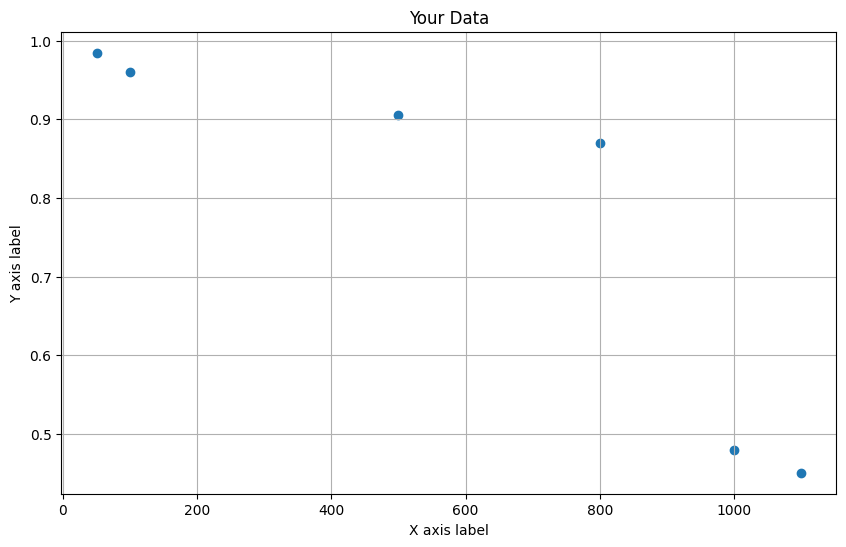

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
data = np.load('/mnt/users/goringn/NNs_vs_Kernels/stair_function/metric_data/ntk_mup_hidden_size1000_n_train_vs_ntk_diff.npy')
print(data[:,1])
# Create a basic plot
plt.figure(figsize=(10, 6))  # Optional: set figure size
plt.scatter(data[:,0],data[:,1])
plt.title('Your Data')
plt.xlabel('X axis label')
plt.ylabel('Y axis label')
plt.grid(True) 
 # Optional: add grid
plt.show()

In [15]:
import os
import h5py
import numpy as np
import json
import glob
from typing import Tuple, Dict
from collections import defaultdict

def centered_kernel_alignment(K1: np.ndarray, K2: np.ndarray) -> float:
    """
    Compute the centered kernel alignment (CKA) between two kernel matrices.
    """
    n = K1.shape[0]
    I = np.eye(n)
    H = I - np.ones((n, n)) / n
    
    K1_centered = H @ K1 @ H
    K2_centered = H @ K2 @ H
    
    hsic = np.sum(K1_centered * K2_centered)
    norm1 = np.sqrt(np.sum(K1_centered * K1_centered))
    norm2 = np.sqrt(np.sum(K2_centered * K2_centered))
    
    return hsic / (norm1 * norm2)

def compute_kernel_diff_metrics(initial_kernels_path: str, final_kernels_path: str) -> Dict:
    """
    Compute various difference metrics between initial and final kernels
    """
    with h5py.File(initial_kernels_path, 'r') as f:
        initial_nngp = f['nngp'][:]
        initial_ntk = f['ntk'][:]
    
    with h5py.File(final_kernels_path, 'r') as f:
        final_nngp = f['nngp'][:]
        final_ntk = f['ntk'][:]
    
    eps = 1e-10
    
    # Compute differences
    nngp_diff = np.mean(np.abs(final_nngp - initial_nngp))
    ntk_diff = np.mean(np.abs(final_ntk - initial_ntk))
    
    # Compute CKA
    nngp_cka = centered_kernel_alignment(initial_nngp, final_nngp)
    ntk_cka = centered_kernel_alignment(initial_ntk, final_ntk)
    
    # Compute normalized Frobenius norms of differences (squared version)
    nngp_frob = (np.linalg.norm(final_nngp - initial_nngp) ) #/ (np.linalg.norm(initial_nngp)  + eps)
    ntk_frob = (np.linalg.norm(final_ntk - initial_ntk) ) #/ (np.linalg.norm(initial_ntk)  + eps)
    
    return {
        'metrics': {
            'nngp_mean_diff': float(nngp_diff),
            'ntk_mean_diff': float(ntk_diff),
            'nngp_cka': float(nngp_cka),
            'ntk_cka': float(ntk_cka),
            'nngp_frob_norm': float(nngp_frob),
            'ntk_frob_norm': float(ntk_frob)
        },
        'raw_differences': {
            'nngp_diff_matrix': final_nngp - initial_nngp,
            'ntk_diff_matrix': final_ntk - initial_ntk,
            'initial_nngp': initial_nngp,
            'initial_ntk': initial_ntk,
            'final_nngp': final_nngp,
            'final_ntk': final_ntk
        }
    }

def analyze_experiment_directory(results_dir: str) -> Dict:
    """
    Analyze all experiments in the directory and organize results by configuration
    """
    results = defaultdict(list)
    raw_data = defaultdict(dict)
    
    history_files = glob.glob(os.path.join(results_dir, 'history_*.json'))
    print(f"Found {len(history_files)} history files")
    
    for history_file in history_files:
        print(f"Processing {history_file}")
        try:
            with open(history_file, 'r') as f:
                history = json.load(f)
            
            params = history['parameters']
            n_train = params['n_train']
            hidden_size = params['hidden_size']
            depth = params['depth']
            mode = params['mode']
            
            base_name = os.path.splitext(os.path.basename(history_file))[0].replace('history_', '')
            initial_kernels = os.path.join(results_dir, f'{base_name}_initial_kernels.h5')
            best_epoch = history['error_history']['best_epoch']
            final_kernels = os.path.join(results_dir, f'{base_name}_best_model_epoch{best_epoch}_kernels.h5')
            
            if not (os.path.exists(initial_kernels) and os.path.exists(final_kernels)):
                print(f"Warning: Missing kernel files for {base_name}")
                print(f"Initial kernels exist: {os.path.exists(initial_kernels)}")
                print(f"Final kernels exist: {os.path.exists(final_kernels)}")
                continue
            
            kernel_data = compute_kernel_diff_metrics(initial_kernels, final_kernels)
            
            config_key = f"h{hidden_size}_d{depth}_{mode}"
            results[config_key].append({
                'n_train': n_train,
                'metrics': kernel_data['metrics'],
                'test_error': history['test_error'],
                'train_error_improvement': history['initial_train_error'] - history['final_train_error']
            })
            
            raw_data[config_key][n_train] = kernel_data['raw_differences']
            
        except Exception as e:
            print(f"Error processing {history_file}: {str(e)}")
            continue
    
    for config in results:
        results[config] = sorted(results[config], key=lambda x: x['n_train'])
        print(f"Config {config}: {len(results[config])} data points")
    
    return results, raw_data

def save_numpy_data(results: Dict, raw_data: Dict, output_dir: str):
    """
    Save results as numpy arrays with descriptive names
    """
    numpy_dir = os.path.join(output_dir, 'numpy_data')
    os.makedirs(numpy_dir, exist_ok=True)
    
    for config, data in results.items():
        # Save n_train values
        n_train_values = np.array([point['n_train'] for point in data])
        np.save(os.path.join(numpy_dir, f'{config}_n_train.npy'), n_train_values)
        
        # Save metric arrays
        for metric_name in data[0]['metrics']:
            metric_values = np.array([point['metrics'][metric_name] for point in data])
            np.save(os.path.join(numpy_dir, f'{config}_{metric_name}.npy'), metric_values)
        
        # Save test errors and training improvements
        test_errors = np.array([point['test_error'] for point in data])
        train_improvements = np.array([point['train_error_improvement'] for point in data])
        np.save(os.path.join(numpy_dir, f'{config}_test_errors.npy'), test_errors)
        np.save(os.path.join(numpy_dir, f'{config}_train_improvements.npy'), train_improvements)
        
        # Save raw differences and kernels
        for n_train in raw_data[config]:
            n_train_dir = os.path.join(numpy_dir, config, f'n_train_{n_train}')
            os.makedirs(n_train_dir, exist_ok=True)
            
            for key, value in raw_data[config][n_train].items():
                np.save(os.path.join(n_train_dir, f'{key}.npy'), value)

def main():
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_yang_critique_400"
    output_dir = os.path.join(results_dir, "kernel_analysis")
    
    print("Analyzing experiments...")
    results, raw_data = analyze_experiment_directory(results_dir)
    
    print("\nConfigurations found:")
    for config in results:
        print(f"{config}: {len(results[config])} points")
    
    print("\nSaving numpy data...")
    save_numpy_data(results, raw_data, output_dir)
    
    print(f"\nAnalysis complete. Results saved to {output_dir}/numpy_data")
    print("\nSaved files for each configuration include:")
    print("- {config}_n_train.npy")
    print("- {config}_{metric_name}.npy")
    print("- {config}_test_errors.npy")
    print("- {config}_train_improvements.npy")
    print("And raw kernel data in subdirectories")

if __name__ == "__main__":
    main()

Analyzing experiments...
Found 8 history files
Processing /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_yang_critique_400/history_msp_NTK_1401_yang_critique_400_h400_d4_n5000_lr0.05_20250114_175209_rank0.json
Processing /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_yang_critique_400/history_msp_NTK_1401_yang_critique_400_h400_d4_n20000_lr0.05_20250114_175209_rank0.json
Processing /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_yang_critique_400/history_msp_NTK_1401_yang_critique_400_h400_d4_n10000_lr0.05_20250114_175209_rank0.json
Processing /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_yang_critique_400/history_msp_NTK_1401_yang_critique_400_h400_d4_n1000_lr0.05_20250114_175209_rank0.json
Processing /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_yang_critique_400/history_msp_NTK_1401_yang_critique_400_h400_d4_n10_lr0.05_20250114_175209_rank0.json
Processing /mnt/users/g

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

def plot_kernel_metrics(data_dir, output_dir):
    """Plot kernel metrics from saved .npy files"""
    
    # Set up clean matplotlib style
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'axes.grid': True,
        'grid.color': '#E6E6E6',
        'axes.edgecolor': 'black',
        'axes.linewidth': 1.0,
        'lines.linewidth': 2.0,
        'font.family': 'sans-serif',
        'font.size': 10
    })
    
    # Define colors and markers for different configurations
    colors = {
        'standard': '#1f77b4',  # blue
        'mup_pennington': '#d62728'  # red
    }
    
    # Find all n_train files to get configurations
    n_train_files = glob.glob(os.path.join(data_dir, '*_n_train.npy'))
    
    # Print found configurations
    print("Found configurations:")
    for f in n_train_files:
        print(os.path.basename(f))
    
    metrics = ['nngp_mean_diff', 'ntk_mean_diff', 'nngp_cka', 'ntk_cka', 
               'nngp_frob_norm', 'ntk_frob_norm']
    
    metric_labels = {
        'nngp_mean_diff': 'NNGP Mean Absolute Difference',
        'ntk_mean_diff': 'NTK Mean Absolute Difference',
        'nngp_cka': 'NNGP CKA',
        'ntk_cka': 'NTK CKA',
        'nngp_frob_norm': 'NNGP Normalized Frobenius Norm',
        'ntk_frob_norm': 'NTK Normalized Frobenius Norm'
    }
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Plot each metric
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        
        # Process and group configurations by hidden size
        configs_by_hidden = {}
        for n_train_file in n_train_files:
            config = os.path.basename(n_train_file).replace('_n_train.npy', '')
            parts = config.split('_')
            hidden_size = parts[0]
            if hidden_size not in configs_by_hidden:
                configs_by_hidden[hidden_size] = []
            configs_by_hidden[hidden_size].append(config)
        
        # Plot each configuration
        for hidden_size in sorted(configs_by_hidden.keys()):
            for config in configs_by_hidden[hidden_size]:
                try:
                    # Load data
                    n_train = np.load(os.path.join(data_dir, f'{config}_n_train.npy'))
                    metric_data = np.load(os.path.join(data_dir, f'{config}_{metric}.npy'))
                    
                    # Parse configuration
                    parts = config.split('_')
                    hidden_size = parts[0].replace('h', '')
                    depth = parts[1].replace('d', '')
                    mode = '_'.join(parts[2:])  # Handle multi-word modes
                    
                    print(f"Plotting {config} - mode: {mode}")
                    
                    # Plot
                    plt.semilogx(n_train, metric_data, 'o-',
                                label=f'h={hidden_size}, d={depth}, {mode}',
                                color=colors[mode],
                                alpha=0.7 if mode == 'standard' else 1.0,
                                linewidth=2)
                except Exception as e:
                    print(f"Error plotting {config}: {str(e)}")
                    continue
        
        plt.grid(True, which="major", linestyle='-', linewidth=0.5, alpha=0.2)
        plt.grid(True, which="minor", linestyle=':', linewidth=0.5, alpha=0.1)
        plt.xlabel('Training Set Size', fontsize=12)
        plt.ylabel(metric_labels[metric], fontsize=12)
        plt.title(f'{metric_labels[metric]} vs Training Set Size', fontsize=14, pad=20)
        
        # Set y-axis limits for normalized metrics
        #if 'norm' in metric or 'cka' in metric:
            #plt.ylim(0, 1.1)
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        plt.tight_layout()
        
        # Save plot
        plt.savefig(os.path.join(output_dir, f'{metric}_vs_ntrain.png'),
                   dpi=300, bbox_inches='tight')
        plt.close()

def main():
    # Adjust these paths to match your directory structure
    data_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_yang_critique_400/kernel_analysis/numpy_data"
    output_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_yang_critique_400/kernel_analysis/plots"
    
    print("Creating plots...")
    plot_kernel_metrics(data_dir, output_dir)
    print("Done! Plots saved to:", output_dir)

if __name__ == "__main__":
    main()

Creating plots...
Found configurations:
h400_d4_mup_pennington_n_train.npy
Plotting h400_d4_mup_pennington - mode: mup_pennington
Plotting h400_d4_mup_pennington - mode: mup_pennington
Plotting h400_d4_mup_pennington - mode: mup_pennington
Plotting h400_d4_mup_pennington - mode: mup_pennington
Plotting h400_d4_mup_pennington - mode: mup_pennington
Plotting h400_d4_mup_pennington - mode: mup_pennington
Done! Plots saved to: /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_yang_critique_400/kernel_analysis/plots


In [1]:
import os
import h5py
import numpy as np
import json
import glob
from typing import Tuple, Dict
from collections import defaultdict

def centered_kernel_alignment(K1: np.ndarray, K2: np.ndarray) -> float:
    """
    Compute the centered kernel alignment (CKA) between two kernel matrices.
    """
    n = K1.shape[0]
    I = np.eye(n)
    H = I - np.ones((n, n)) / n
    
    K1_centered = H @ K1 @ H
    K2_centered = H @ K2 @ H
    
    hsic = np.sum(K1_centered * K2_centered)
    norm1 = np.sqrt(np.sum(K1_centered * K1_centered))
    norm2 = np.sqrt(np.sum(K2_centered * K2_centered))
    
    return hsic / (norm1 * norm2)

def compute_kernel_diff_metrics(initial_kernels_path: str, final_kernels_path: str) -> Dict:
    """
    Compute various difference metrics between initial and final kernels
    """
    with h5py.File(initial_kernels_path, 'r') as f:
        initial_nngp = f['nngp'][:]
        initial_ntk = f['ntk'][:]
    
    with h5py.File(final_kernels_path, 'r') as f:
        final_nngp = f['nngp'][:]
        final_ntk = f['ntk'][:]
    
    eps = 1e-10
    
    # Compute differences
    nngp_diff = np.mean(np.abs(final_nngp - initial_nngp))
    ntk_diff = np.mean(np.abs(final_ntk - initial_ntk))
    
    # Compute CKA
    nngp_cka = centered_kernel_alignment(initial_nngp, final_nngp)
    ntk_cka = centered_kernel_alignment(initial_ntk, final_ntk)
    
    # Compute normalized Frobenius norms of differences (squared version)
    nngp_frob = (np.linalg.norm(final_nngp - initial_nngp) ) #/ (np.linalg.norm(initial_nngp)  + eps)
    ntk_frob = (np.linalg.norm(final_ntk - initial_ntk) ) #/ (np.linalg.norm(initial_ntk)  + eps)
    
    return {
        'metrics': {
            'nngp_mean_diff': float(nngp_diff),
            'ntk_mean_diff': float(ntk_diff),
            'nngp_cka': float(nngp_cka),
            'ntk_cka': float(ntk_cka),
            'nngp_frob_norm': float(nngp_frob),
            'ntk_frob_norm': float(ntk_frob)
        },
        'raw_differences': {
            'nngp_diff_matrix': final_nngp - initial_nngp,
            'ntk_diff_matrix': final_ntk - initial_ntk,
            'initial_nngp': initial_nngp,
            'initial_ntk': initial_ntk,
            'final_nngp': final_nngp,
            'final_ntk': final_ntk
        }
    }

def analyze_experiment_directory(results_dir: str) -> Dict:
    """
    Analyze all experiments in the directory and organize results by configuration
    """
    results = defaultdict(list)
    raw_data = defaultdict(dict)
    
    history_files = glob.glob(os.path.join(results_dir, 'history_*.json'))
    print(f"Found {len(history_files)} history files")
    
    for history_file in history_files:
        print(f"Processing {history_file}")
        try:
            with open(history_file, 'r') as f:
                history = json.load(f)
            
            params = history['parameters']
            n_train = params['n_train']
            hidden_size = params['hidden_size']
            depth = params['depth']
            mode = params['mode']
            
            base_name = os.path.splitext(os.path.basename(history_file))[0].replace('history_', '')
            initial_kernels = os.path.join(results_dir, f'{base_name}_initial_kernels.h5')
            #best_epoch = history['error_history']['best_epoch']
            final_kernels = os.path.join(results_dir, f'{base_name}_final_kernels.h5')
            #final_kernels = os.path.join(results_dir, f'{base_name}_best_model_epoch{best_epoch}_kernels.h5')
            
            if not (os.path.exists(initial_kernels) and os.path.exists(final_kernels)):
                print(f"Warning: Missing kernel files for {base_name}")
                print(f"Initial kernels exist: {os.path.exists(initial_kernels)}")
                print(f"Final kernels exist: {os.path.exists(final_kernels)}")
                continue
            
            kernel_data = compute_kernel_diff_metrics(initial_kernels, final_kernels)
            
            config_key = f"h{hidden_size}_d{depth}_{mode}"
            results[config_key].append({
                'n_train': n_train,
                'metrics': kernel_data['metrics'],
                'test_error': history['test_error'],
                'train_error_improvement': history['initial_train_error'] - history['final_train_error']
            })
            
            raw_data[config_key][n_train] = kernel_data['raw_differences']
            
        except Exception as e:
            print(f"Error processing {history_file}: {str(e)}")
            continue
    
    for config in results:
        results[config] = sorted(results[config], key=lambda x: x['n_train'])
        print(f"Config {config}: {len(results[config])} data points")
    
    return results, raw_data

def save_numpy_data(results: Dict, raw_data: Dict, output_dir: str):
    """
    Save results as numpy arrays with descriptive names
    """
    numpy_dir = os.path.join(output_dir, 'numpy_data')
    os.makedirs(numpy_dir, exist_ok=True)
    
    for config, data in results.items():
        # Save n_train values
        n_train_values = np.array([point['n_train'] for point in data])
        np.save(os.path.join(numpy_dir, f'{config}_n_train.npy'), n_train_values)
        
        # Save metric arrays
        for metric_name in data[0]['metrics']:
            metric_values = np.array([point['metrics'][metric_name] for point in data])
            np.save(os.path.join(numpy_dir, f'{config}_{metric_name}.npy'), metric_values)
        
        # Save test errors and training improvements
        test_errors = np.array([point['test_error'] for point in data])
        train_improvements = np.array([point['train_error_improvement'] for point in data])
        np.save(os.path.join(numpy_dir, f'{config}_test_errors.npy'), test_errors)
        np.save(os.path.join(numpy_dir, f'{config}_train_improvements.npy'), train_improvements)
        
        # Save raw differences and kernels
        for n_train in raw_data[config]:
            n_train_dir = os.path.join(numpy_dir, config, f'n_train_{n_train}')
            os.makedirs(n_train_dir, exist_ok=True)
            
            for key, value in raw_data[config][n_train].items():
                np.save(os.path.join(n_train_dir, f'{key}.npy'), value)

def main():
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_shuffledtrue"
    output_dir = os.path.join(results_dir, "kernel_analysis")
    
    print("Analyzing experiments...")
    results, raw_data = analyze_experiment_directory(results_dir)
    
    print("\nConfigurations found:")
    for config in results:
        print(f"{config}: {len(results[config])} points")
    
    print("\nSaving numpy data...")
    save_numpy_data(results, raw_data, output_dir)
    
    print(f"\nAnalysis complete. Results saved to {output_dir}/numpy_data")
    print("\nSaved files for each configuration include:")
    print("- {config}_n_train.npy")
    print("- {config}_{metric_name}.npy")
    print("- {config}_test_errors.npy")
    print("- {config}_train_improvements.npy")
    print("And raw kernel data in subdirectories")

if __name__ == "__main__":
    main()

Analyzing experiments...
Found 9 history files
Processing /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_shuffledtrue/history_msp_NTK_1401_shuffledtrue_h400_d4_n10000_lr0.001_shuffled_20250115_174821_rank0.json
Initial kernels exist: True
Final kernels exist: False
Processing /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_shuffledtrue/history_msp_NTK_1401_shuffledtrue_h400_d4_n500_lr0.001_shuffled_20250115_174821_rank0.json
Initial kernels exist: True
Final kernels exist: False
Processing /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_shuffledtrue/history_msp_NTK_1401_shuffledtrue_h400_d4_n1000_lr0.001_shuffled_20250115_174821_rank0.json
Initial kernels exist: True
Final kernels exist: False
Processing /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NTK_1401_shuffledtrue/history_msp_NTK_1401_shuffledtrue_h400_d4_n50_lr0.001_shuffled_20250115_174821_rank0.json
Initial kernels exist: True
Final kernels exis

In [ ]:
#### new sciprt

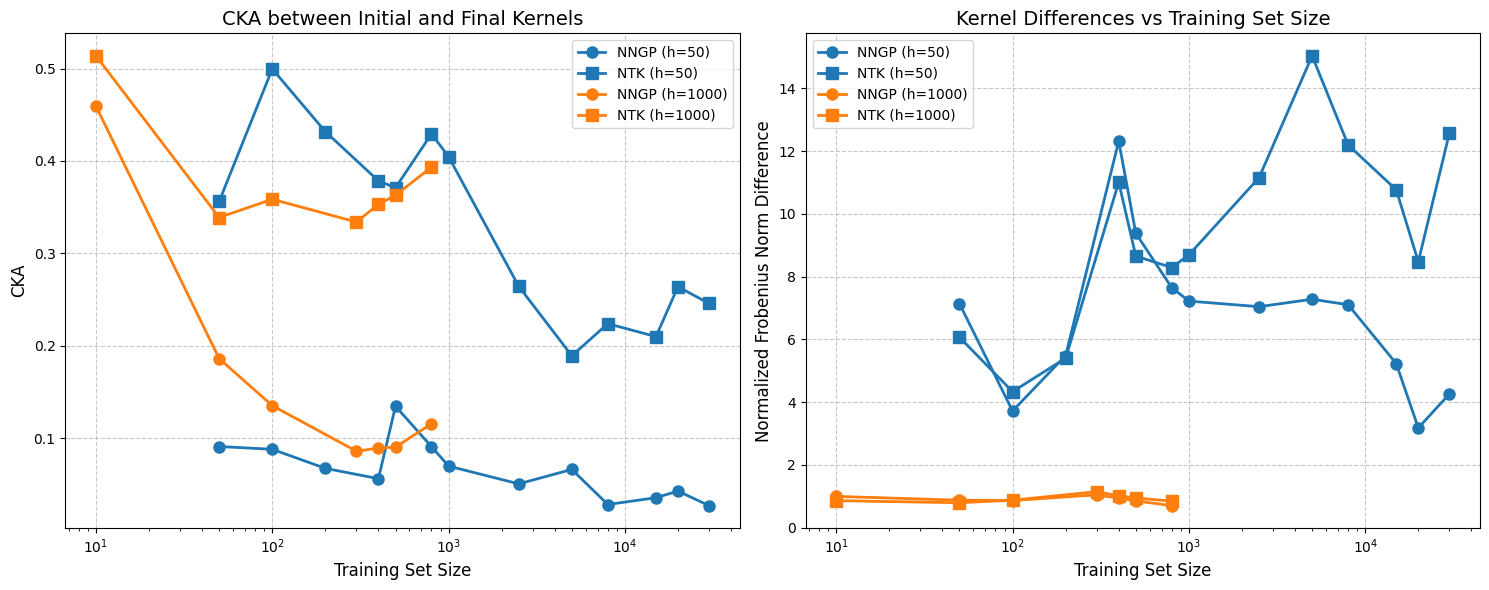

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from typing import List, Dict

def parse_hidden_width(filename: str) -> int:
    """Extract hidden width (h) from the filename."""
    pattern = r'h(\d+)_d\d+_n\d+_lr[\d\.]+_\w+'
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))
    raise ValueError(f"Couldn't parse hidden width from filename: {filename}")

def load_all_metrics(kernel_dir: str) -> List[Dict]:
    """Load all metric files from the directory, including hidden width."""
    pattern = os.path.join(kernel_dir, "*_metrics.npy")
    metric_files = glob.glob(pattern)
    
    metrics_list = []
    for metric_file in metric_files:
        metrics = np.load(metric_file, allow_pickle=True).item()
        metrics['hidden_width'] = parse_hidden_width(metric_file)
        metrics_list.append(metrics)
    
    return sorted(metrics_list, key=lambda x: (x['hidden_width'], x['n_train']))

# Load metrics
models_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp"
kernel_dir = os.path.join(models_dir, "kernel_analysis")
metrics_list = load_all_metrics(kernel_dir)

# Group metrics by hidden width
hidden_widths = sorted(set(m['hidden_width'] for m in metrics_list))
grouped_metrics = {h: [m for m in metrics_list if m['hidden_width'] == h] for h in hidden_widths}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Add more colors if needed

# Plot for each hidden width
for idx, h in enumerate(hidden_widths):
    group = grouped_metrics[h]
    n_train_values = [m['n_train'] for m in group]
    nngp_cka = [m['nngp_cka'] for m in group]
    ntk_cka = [m['ntk_cka'] for m in group]
    nngp_frob = [m['nngp_frob'] for m in group]
    ntk_frob = [m['ntk_frob'] for m in group]

    # Plot CKA values
    ax1.plot(n_train_values, nngp_cka, 'o-', label=f'NNGP (h={h})', color=colors[idx % len(colors)], linewidth=2, markersize=8)
    ax1.plot(n_train_values, ntk_cka, 's-', label=f'NTK (h={h})', color=colors[idx % len(colors)], linewidth=2, markersize=8)

    # Plot Frobenius norm differences
    ax2.plot(n_train_values, nngp_frob, 'o-', label=f'NNGP (h={h})', color=colors[idx % len(colors)], linewidth=2, markersize=8)
    ax2.plot(n_train_values, ntk_frob, 's-', label=f'NTK (h={h})', color=colors[idx % len(colors)], linewidth=2, markersize=8)

# Customize plots
ax1.set_xscale('log')
ax1.set_xlabel('Training Set Size', fontsize=12)
ax1.set_ylabel('CKA', fontsize=12)
ax1.set_title('CKA between Initial and Final Kernels', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='both', which='major', labelsize=10)

ax2.set_xscale('log')
ax2.set_xlabel('Training Set Size', fontsize=12)
ax2.set_ylabel('Normalized Frobenius Norm Difference', fontsize=12)
ax2.set_title('Kernel Differences vs Training Set Size', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


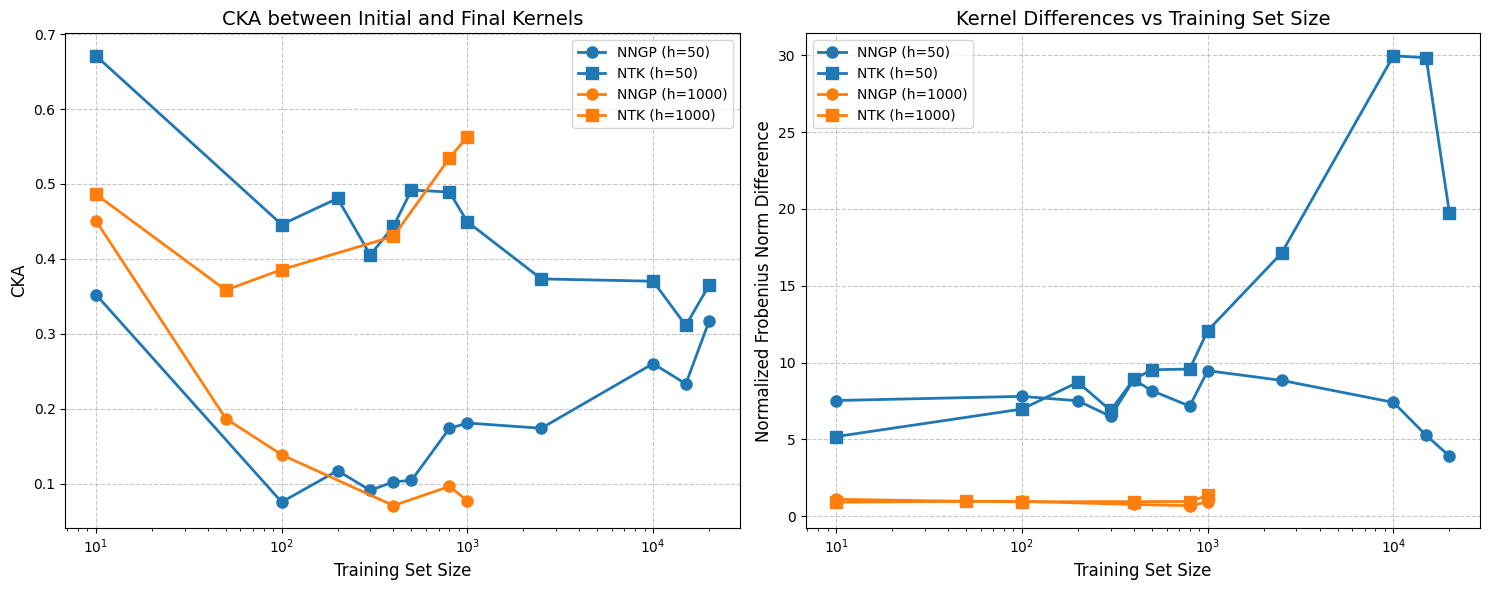

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from typing import List, Dict

def parse_hidden_width(filename: str) -> int:
    """Extract hidden width (h) from the filename."""
    pattern = r'h(\d+)_d\d+_n\d+_lr[\d\.]+_\w+'
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))
    raise ValueError(f"Couldn't parse hidden width from filename: {filename}")

def load_all_metrics(kernel_dir: str) -> List[Dict]:
    """Load all metric files from the directory, including hidden width."""
    pattern = os.path.join(kernel_dir, "*_metrics.npy")
    metric_files = glob.glob(pattern)
    
    metrics_list = []
    for metric_file in metric_files:
        metrics = np.load(metric_file, allow_pickle=True).item()
        metrics['hidden_width'] = parse_hidden_width(metric_file)
        metrics_list.append(metrics)
    
    return sorted(metrics_list, key=lambda x: (x['hidden_width'], x['n_train']))

# Load metrics
models_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_antro_newmsp"
kernel_dir = os.path.join(models_dir, "kernel_analysis")
metrics_list = load_all_metrics(kernel_dir)

# Group metrics by hidden width
hidden_widths = sorted(set(m['hidden_width'] for m in metrics_list))
grouped_metrics = {h: [m for m in metrics_list if m['hidden_width'] == h] for h in hidden_widths}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Add more colors if needed

# Plot for each hidden width
for idx, h in enumerate(hidden_widths):
    group = grouped_metrics[h]
    n_train_values = [m['n_train'] for m in group]
    nngp_cka = [m['nngp_cka'] for m in group]
    ntk_cka = [m['ntk_cka'] for m in group]
    nngp_frob = [m['nngp_frob'] for m in group]
    ntk_frob = [m['ntk_frob'] for m in group]

    # Plot CKA values
    ax1.plot(n_train_values, nngp_cka, 'o-', label=f'NNGP (h={h})', color=colors[idx % len(colors)], linewidth=2, markersize=8)
    ax1.plot(n_train_values, ntk_cka, 's-', label=f'NTK (h={h})', color=colors[idx % len(colors)], linewidth=2, markersize=8)

    # Plot Frobenius norm differences
    ax2.plot(n_train_values, nngp_frob, 'o-', label=f'NNGP (h={h})', color=colors[idx % len(colors)], linewidth=2, markersize=8)
    ax2.plot(n_train_values, ntk_frob, 's-', label=f'NTK (h={h})', color=colors[idx % len(colors)], linewidth=2, markersize=8)

# Customize plots
ax1.set_xscale('log')
ax1.set_xlabel('Training Set Size', fontsize=12)
ax1.set_ylabel('CKA', fontsize=12)
ax1.set_title('CKA between Initial and Final Kernels', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='both', which='major', labelsize=10)

ax2.set_xscale('log')
ax2.set_xlabel('Training Set Size', fontsize=12)
ax2.set_ylabel('Normalized Frobenius Norm Difference', fontsize=12)
ax2.set_title('Kernel Differences vs Training Set Size', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


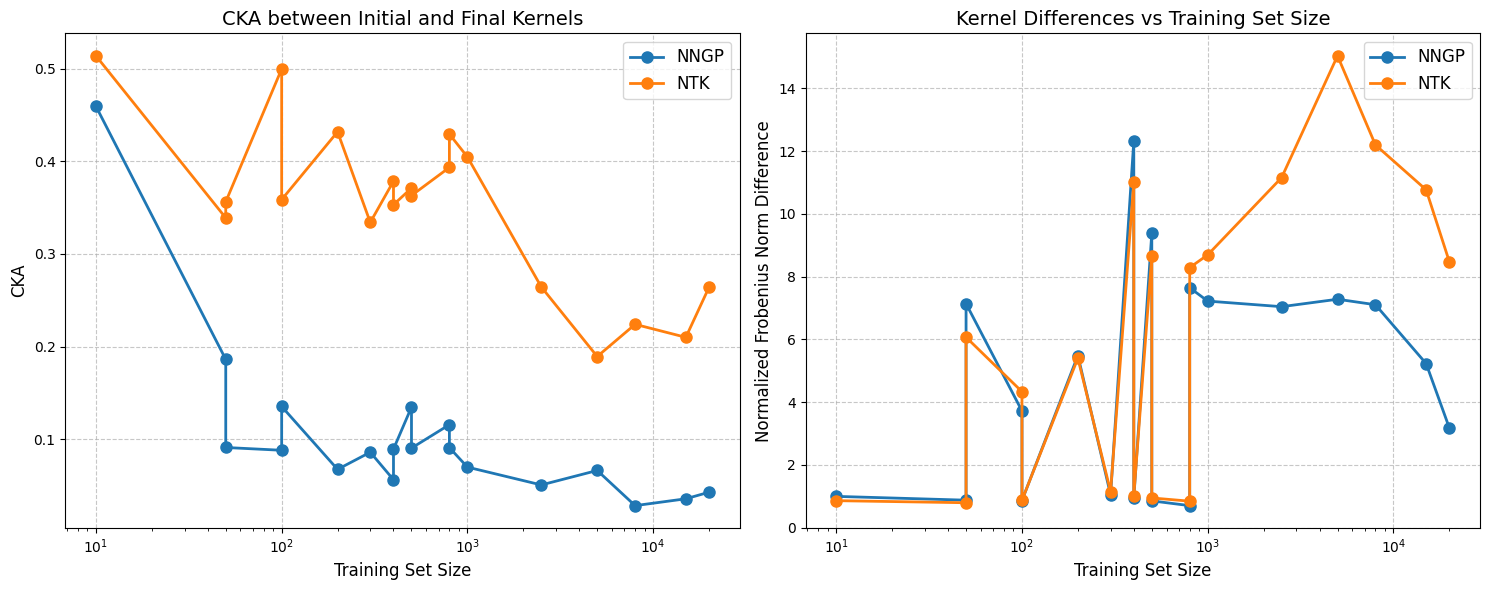

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from typing import List, Dict

def load_all_metrics(kernel_dir: str) -> List[Dict]:
    """Load all metric files from the directory."""
    pattern = os.path.join(kernel_dir, "*_metrics.npy")
    metric_files = glob.glob(pattern)
    
    metrics_list = []
    for metric_file in metric_files:
        metrics = np.load(metric_file, allow_pickle=True).item()
        metrics_list.append(metrics)
    
    return sorted(metrics_list, key=lambda x: x['n_train'])

# Load metrics
models_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp"
kernel_dir = os.path.join(models_dir, "kernel_analysis")
metrics_list = load_all_metrics(kernel_dir)

# Extract data
n_train_values = [m['n_train'] for m in metrics_list]
nngp_cka = [m['nngp_cka'] for m in metrics_list]
ntk_cka = [m['ntk_cka'] for m in metrics_list]
nngp_frob = [m['nngp_frob'] for m in metrics_list]
ntk_frob = [m['ntk_frob'] for m in metrics_list]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot CKA values
ax1.plot(n_train_values, nngp_cka, 'o-', label='NNGP', color='#1f77b4', linewidth=2, markersize=8)
ax1.plot(n_train_values, ntk_cka, 'o-', label='NTK', color='#ff7f0e', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('Training Set Size', fontsize=12)
ax1.set_ylabel('CKA', fontsize=12)
ax1.set_title('CKA between Initial and Final Kernels', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Plot Frobenius norm differences
ax2.plot(n_train_values, nngp_frob, 'o-', label='NNGP', color='#1f77b4', linewidth=2, markersize=8)
ax2.plot(n_train_values, ntk_frob, 'o-', label='NTK', color='#ff7f0e', linewidth=2, markersize=8)
ax2.set_xscale('log')
ax2.set_xlabel('Training Set Size', fontsize=12)
ax2.set_ylabel('Normalized Frobenius Norm Difference', fontsize=12)
ax2.set_title('Kernel Differences vs Training Set Size', fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

In [1]:
#!/usr/bin/env python3
import numpy as np
import os
import glob
import re
from typing import Tuple

def center_kernel(K: np.ndarray) -> np.ndarray:
    """Center the kernel matrix."""
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ K @ H

def compute_cka(K1: np.ndarray, K2: np.ndarray) -> float:
    """Compute Linear CKA between two kernel matrices."""
    K1 = center_kernel(K1)
    K2 = center_kernel(K2)
    
    hsic = np.sum(K1 * K2)
    normalization = np.sqrt(np.sum(K1 * K1) * np.sum(K2 * K2))
    
    return hsic / normalization if normalization > 0 else 0

def compute_frobenius_norm_diff(K1: np.ndarray, K2: np.ndarray) -> float:
    """Compute normalized Frobenius norm of the difference between kernels."""
    diff_norm = np.linalg.norm(K1 - K2, ord='fro')
    normalization = np.sqrt(np.linalg.norm(K1, ord='fro') * np.linalg.norm(K2, ord='fro'))
    
    return diff_norm / normalization if normalization > 0 else 0

def parse_n_train(filename: str) -> int:
    """Extract n_train from filename."""
    pattern = r'h\d+_d\d+_n(\d+)_lr[\d\.]+_\w+'
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))
    raise ValueError(f"Couldn't parse n_train from filename: {filename}")

def process_kernel_pair(base_path: str) -> Tuple[dict, bool]:
    """Process a pair of initial and final kernel files."""
    try:
        # Load kernels
        initial_nngp = np.load(f"{base_path}_initial_kernels_nngp.npy")
        initial_ntk = np.load(f"{base_path}_initial_kernels_ntk.npy")
        final_nngp = np.load(f"{base_path}_final_kernels_nngp.npy")
        final_ntk = np.load(f"{base_path}_final_kernels_ntk.npy")

        # Compute metrics
        metrics = {
            'nngp_cka': compute_cka(initial_nngp, final_nngp),
            'ntk_cka': compute_cka(initial_ntk, final_ntk),
            'nngp_frob': compute_frobenius_norm_diff(initial_nngp, final_nngp),
            'ntk_frob': compute_frobenius_norm_diff(initial_ntk, final_ntk),
            'n_train': parse_n_train(base_path)
        }

        # Save metrics
        np.save(f"{base_path}_metrics.npy", metrics)
        
        return metrics, True
    except Exception as e:
        print(f"Error processing {base_path}: {str(e)}")
        return {}, False

def main():
    # Use the same directory structure as the original script
    models_dir = "//mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp"
    kernel_dir = os.path.join(models_dir, "kernel_analysis")
    
    # Find all kernel files
    pattern = os.path.join(kernel_dir, "*_initial_kernels_nngp.npy")
    initial_kernel_files = glob.glob(pattern)
    
    results = []
    for initial_kernel_file in initial_kernel_files:
        print(initial_kernel_file)
        base_path = initial_kernel_file.replace("_initial_kernels_nngp.npy", "")
        metrics, success = process_kernel_pair(base_path)
        if success:
            results.append(metrics)
    
    print(f"Processed {len(results)} kernel pairs successfully")

if __name__ == "__main__":
    main()

//mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/kernel_analysis/h1000_d4_n100_lr0.001_mup_pennington_20250104_183809_rank0_initial_kernels_nngp.npy
//mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/kernel_analysis/h50_d4_n20000_lr0.001_mup_pennington_20250104_183809_rank0_initial_kernels_nngp.npy
//mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/kernel_analysis/h50_d4_n8000_lr0.001_mup_pennington_20250104_183809_rank0_initial_kernels_nngp.npy
//mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/kernel_analysis/h1000_d4_n400_lr0.001_mup_pennington_20250104_183809_rank0_initial_kernels_nngp.npy
//mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/kernel_analysis/h50_d4_n100_lr0.001_mup_pennington_20250104_1

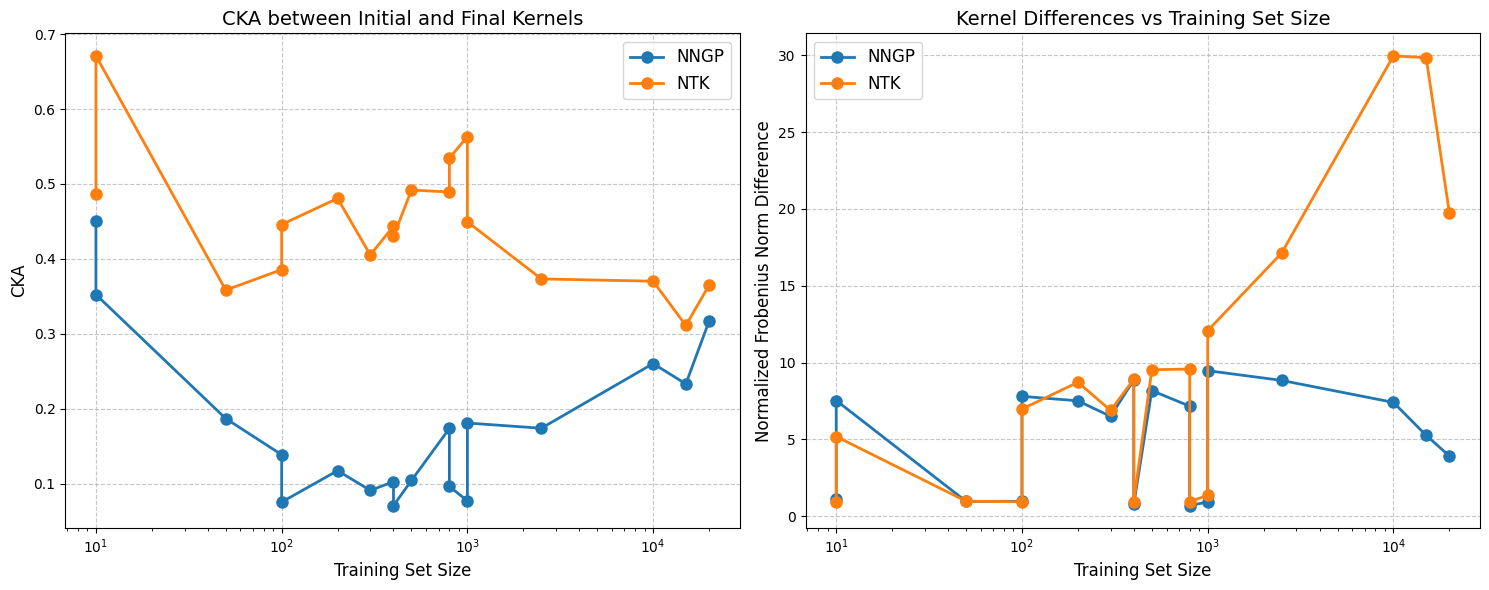

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from typing import List, Dict

def load_all_metrics(kernel_dir: str) -> List[Dict]:
    """Load all metric files from the directory."""
    pattern = os.path.join(kernel_dir, "*_metrics.npy")
    metric_files = glob.glob(pattern)
    
    metrics_list = []
    for metric_file in metric_files:
        metrics = np.load(metric_file, allow_pickle=True).item()
        metrics_list.append(metrics)
    
    return sorted(metrics_list, key=lambda x: x['n_train'])

# Load metrics
models_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_antro_newmsp"
kernel_dir = os.path.join(models_dir, "kernel_analysis")
metrics_list = load_all_metrics(kernel_dir)

# Extract data
n_train_values = [m['n_train'] for m in metrics_list]
nngp_cka = [m['nngp_cka'] for m in metrics_list]
ntk_cka = [m['ntk_cka'] for m in metrics_list]
nngp_frob = [m['nngp_frob'] for m in metrics_list]
ntk_frob = [m['ntk_frob'] for m in metrics_list]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot CKA values
ax1.plot(n_train_values, nngp_cka, 'o-', label='NNGP', color='#1f77b4', linewidth=2, markersize=8)
ax1.plot(n_train_values, ntk_cka, 'o-', label='NTK', color='#ff7f0e', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('Training Set Size', fontsize=12)
ax1.set_ylabel('CKA', fontsize=12)
ax1.set_title('CKA between Initial and Final Kernels', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Plot Frobenius norm differences
ax2.plot(n_train_values, nngp_frob, 'o-', label='NNGP', color='#1f77b4', linewidth=2, markersize=8)
ax2.plot(n_train_values, ntk_frob, 'o-', label='NTK', color='#ff7f0e', linewidth=2, markersize=8)
ax2.set_xscale('log')
ax2.set_xlabel('Training Set Size', fontsize=12)
ax2.set_ylabel('Normalized Frobenius Norm Difference', fontsize=12)
ax2.set_title('Kernel Differences vs Training Set Size', fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

In [9]:
x=np.load('/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_antro_newmsp/kernel_analysis/h1000_d4_n10_lr0.001_mup_pennington_shuffled_20250104_184500_rank0_metrics.npy', allow_pickle=True)
print(x)

{'nngp_cka': np.float64(0.45093329430387274), 'ntk_cka': np.float64(0.48622026358383436), 'nngp_frob': np.float32(1.1115309), 'ntk_frob': np.float32(0.91886556), 'n_train': 10}
